# Resnet
This notebook contains a test of using resnet.

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import os,sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time


# import torch
import torchvision
# from torch import nn
# from torch import optim
# from torch.utils.data import DataLoader
from torchvision import transforms


#seed for reproducible results
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [3]:
# Function that implements random cropping

from random import random

def uniform(a,b):
    return(a+(b-a)*random())

def img_rnd_crop(im, w, h, i = -1, j = -1):
    is_2d = len(im.shape) < 3
    imgwidth = im.shape[len(im.shape)-2]
    imgheight = im.shape[len(im.shape)-1]
    if (i == -1 and j == -1):
        i = int(uniform(0, imgwidth-w-1))
        j = int(uniform(0, imgheight-h-1))
    if is_2d:
        im_patch = im[i:i+w, j:j+h]
    else:
        im_patch = im[:, i:i+w, j:j+h]
    return im_patch, i, j

Load data.

In [4]:
end_train = 500 # normally = 90
end_validation = 550 # normally = 100

# Loading a set of 100 training images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)]).swapaxes(1,3).swapaxes(2,3)
print(np.shape(imgs))

# train_input = imgs[0:end_train] #normally = 0:90
# validation_input = imgs[end_train:end_validation] #normally = 90:100

image_dir = root_dir + "groundtruth/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
grounds = [load_image(image_dir + files[i]) for i in range(n)]
print(np.shape(grounds))

imgs = np.array(imgs)
grounds = np.array(grounds)

# train_target = grounds[0:end_train] #normally = 0:90
# validation_target = grounds[end_train:end_validation] #normally = 90:100

Loading 100 images
(100, 3, 400, 400)
Loading 100 images
(100, 400, 400)


Crop data to their 256*256 counterparts.

In [5]:
def rotated_expansion(imgs):
    shape = [imgs.shape[i] for i in range(len(imgs.shape))]
    shape[0] = shape[0]*4 # there will be 4 times as many images after we rotate in each direction
    shape = tuple(shape)
    rotated_imgs = np.empty(shape)
    
    for index in range(int(shape[0]/4)):
        img = imgs[index]
        if(len(np.shape(img))>2):
            img90 = np.rot90(img.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
            img180 = np.rot90(img90.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
            img270 = np.rot90(img180.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
        else:
            img90 = np.rot90(img)
            img180 = np.rot90(img90)
            img270 = np.rot90(img180)
        
        rotated_imgs[index*4] = img
        rotated_imgs[index*4+1] = img90
        rotated_imgs[index*4+2] = img180
        rotated_imgs[index*4+3] = img270
    
    return rotated_imgs

rotated_grounds = rotated_expansion(grounds)
rotated_imgs = rotated_expansion(imgs)

def flipped_expansion(imgs):
    shape = [imgs.shape[i] for i in range(len(imgs.shape))]
    shape[0] = shape[0]*3 # there will be 4 times as many images after we rotate in each direction
    shape = tuple(shape)
    flipped_imgs = np.empty(shape)
    
    for index in range(int(shape[0]/3)):
        img = imgs[index]
        if(len(np.shape(img))>2):
            imgup = np.flipud(img.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
            imglr = np.fliplr(img.swapaxes(1,2).swapaxes(0,2)).swapaxes(0,2).swapaxes(1,2)
        else:
            imgup = np.flipud(img)
            imglr = np.fliplr(img)
        
        flipped_imgs[index*3] = img
        flipped_imgs[index*3+1] = imgup
        flipped_imgs[index*3+2] = imglr
    
    return flipped_imgs

flipped_rotated_grounds = flipped_expansion(rotated_grounds)
flipped_rotated_imgs = flipped_expansion(rotated_imgs)

display(np.shape(flipped_rotated_grounds))
display(np.shape(flipped_rotated_imgs))

(1200, 400, 400)

(1200, 3, 400, 400)

In [6]:
# crop images to their 256*256 counterparts
cropped_imgs = []
cropped_targets = []

for i in range(1200):
    cropped_img, k, l = img_rnd_crop(flipped_rotated_imgs[i], 256, 256)
    cropped_target, _, _ = img_rnd_crop(flipped_rotated_grounds[i], 256, 256, k, l)
    cropped_imgs.append(cropped_img)
    cropped_targets.append(cropped_target)

In [7]:
import random

x = list(range(1200))
random.shuffle(x)

train_input = [cropped_imgs[i] for i in x[:end_train]] #normally = 0:1080
validation_input = [cropped_imgs[i] for i in x[end_train:end_validation]] #normally = 1080:1200



train_target = [cropped_targets[i] for i in x[:end_train]] #normally = 0:1080
validation_target = [cropped_targets[i] for i in x[end_train:end_validation]] #normally = 1080:1200

display(np.shape(train_input))
display(np.shape(validation_input))
display(np.shape(train_target))
display(np.shape(validation_target))

(500, 3, 256, 256)

(50, 3, 256, 256)

(500, 256, 256)

(50, 256, 256)

## Pytorch module

This module contains the FCN based on the CNN module

### Module structure

We use Resnet-50

In [8]:
# This class takes our input of size 400*400 and enlarges it to size 512*512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



res50_conv = torch.nn.Sequential(*list(
        torchvision.models.resnet50(pretrained=True).children())[:-2])  # get all layers except avg-pool & fc


# for p in res50_conv.parameters():
#     p.requires_grad=False

model = torch.nn.Sequential(
    res50_conv,  # encoder
    torch.nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),  # 2x upsample
    torch.nn.BatchNorm2d(1024),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 2x upsample
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(512, 256, kernel_size=6, stride=4, padding=1),  # 4x upsample
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 2x upsample
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0),  # logits per pixel
    torch.nn.Sigmoid()  # predictions per pixel  # could remove and use BCEWithLogitsLoss instead of BCELoss.
)
model.to(device)



for p in model.parameters():
    try:
        torch.nn.init.xavier_normal_(p)
    except ValueError:
        pass
    
    
# model = torch.load('best_model100.pth')
# model.eval()

New Lossfunction

In [9]:
from PIL import Image


class GrayscaleAndThreshold:
    """ Reduce image to a single binary channel """
    def __init__(self, level=0.1):
        self.level = level

    def __call__(self, img):
        img = img.convert('L')  # 0..255, single channel

        np_img = np.array(img, dtype=np.uint8)
        np_img[np_img > self.level*255] = 255
        np_img[np_img <= self.level*255] = 0

        img = Image.fromarray(np_img, 'L')

        return img

class WeightedBCELoss(torch.nn.BCELoss):
    def __init__(self, class_weights=None):  # does not support weight, size_average, reduce, reduction
        super().__init__(reduction='none')
        if class_weights is None:
            class_weights = torch.ones(2)
        self.class_weights = torch.as_tensor(class_weights)

    def forward(self, input, target):
        raw_loss = super().forward(input, target)
        class_weights = self.class_weights.to(input.device)
        weight_matrix = class_weights[0]*(1-target) + class_weights[1]*target
        loss = weight_matrix * raw_loss
        loss = loss.mean()  # reduction='elementwise_mean'
        return loss


def compute_class_weights(imgs):
    mask_transform = transforms.Compose([
        GrayscaleAndThreshold(),
        transforms.ToTensor()
        ])

    road_pxs = 0
    bg_pxs = 0
    for img in imgs:
        img = Image.fromarray(np.uint8(img*255))
        mask_tr = torch.squeeze(mask_transform(img)).numpy().astype(int)
        road_pxs += mask_tr.sum()
        bg_pxs += (1 - mask_tr).sum()

    bg_px_weight = (road_pxs + bg_pxs) / (2 * bg_pxs)  # "class 0"
    road_px_weight = (road_pxs + bg_pxs) / (2 * road_pxs)  # "class 1"

    return bg_px_weight, road_px_weight


In [10]:
# Data statistics
class_weights = compute_class_weights(train_target)

criterion = WeightedBCELoss(class_weights)

This model optimized with adam and cross entropy will converge to all-black images every time

## Training the model

To shorten the computationnal time we will use a smaller amount of images to do tests.

### Instantiate the model, loss function and optimizer

In [11]:
# We will optimize the cross-entropy loss using adam algorithm
loss_function = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=3.75e-2, momentum=0.9)

In [12]:
from torchvision import transforms

def trainNet(model, n_epochs):
    loss_train_epoch =[]
    loss_validation_epoch =[]
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        total_loss = 0.0
        
        for index in range(np.shape(train_input)[0]):
            model.train()
            
            input_image = torch.tensor(train_input[index]).unsqueeze(0).to(device)
            target_image = torch.tensor(train_target[index]).to(device)
            
            #Forward pass, backward pass, optimize
            outputs = model(input_image.float())
            loss = criterion(outputs, target_image.float())
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #Print statistics
            total_loss += loss.item() * input_image.size(0)
            
            print("Epoch", epoch, ", image", index, ", image loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for index in range(np.shape(validation_input)[0]):
            model.eval()
                        
            
            input_image = torch.tensor(validation_input[index]).unsqueeze(0).to(device)
            target_image = torch.tensor(validation_target[index]).to(device)
            
            #Forward pass
            val_outputs = model(input_image.float())
            val_loss = criterion(val_outputs, target_image.float())
            total_val_loss += val_loss.item() * input_image.size(0)
            
        print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])
        
        loss_train_epoch.append(total_loss/np.shape(train_input)[0])
        loss_validation_epoch.append(total_val_loss/np.shape(validation_input)[0])
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    torch.save(model, 'best_model.pth')
    return loss_train_epoch, loss_validation_epoch

In [13]:
losstrain, loss_validation = trainNet(model, 20)

C:\Users\morin\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0 , image 0 , image loss: 0.5215343236923218 , time elapsed: 1.4971685409545898
Epoch 0 , image 1 , image loss: 0.6588677763938904 , time elapsed: 1.7714357376098633
Epoch 0 , image 2 , image loss: 0.7871137857437134 , time elapsed: 2.0347299575805664
Epoch 0 , image 3 , image loss: 0.8970526456832886 , time elapsed: 2.2980568408966064
Epoch 0 , image 4 , image loss: 0.6398804187774658 , time elapsed: 2.555325508117676
Epoch 0 , image 5 , image loss: 0.5988691449165344 , time elapsed: 2.818161725997925
Epoch 0 , image 6 , image loss: 0.6062568426132202 , time elapsed: 3.074476718902588
Epoch 0 , image 7 , image loss: 0.9939857721328735 , time elapsed: 3.3357772827148438
Epoch 0 , image 8 , image loss: 0.7968118190765381 , time elapsed: 3.597078323364258
Epoch 0 , image 9 , image loss: 0.7170718312263489 , time elapsed: 3.8643627166748047
Epoch 0 , image 10 , image loss: 0.8195395469665527 , time elapsed: 4.124666213989258
Epoch 0 , image 11 , image loss: 0.6251574754714966 , time

Epoch 0 , image 94 , image loss: 0.5198415517807007 , time elapsed: 26.12480926513672
Epoch 0 , image 95 , image loss: 0.5603813529014587 , time elapsed: 26.38910675048828
Epoch 0 , image 96 , image loss: 0.6576886773109436 , time elapsed: 26.65438961982727
Epoch 0 , image 97 , image loss: 0.727712094783783 , time elapsed: 26.909711837768555
Epoch 0 , image 98 , image loss: 0.5790131688117981 , time elapsed: 27.173012018203735
Epoch 0 , image 99 , image loss: 0.6780047416687012 , time elapsed: 27.43726682662964
Epoch 0 , image 100 , image loss: 0.8830971121788025 , time elapsed: 27.699564456939697
Epoch 0 , image 101 , image loss: 0.8576341867446899 , time elapsed: 27.96585178375244
Epoch 0 , image 102 , image loss: 0.5317569971084595 , time elapsed: 28.226207971572876
Epoch 0 , image 103 , image loss: 0.7936090230941772 , time elapsed: 28.483519554138184
Epoch 0 , image 104 , image loss: 0.7096054553985596 , time elapsed: 28.73981809616089
Epoch 0 , image 105 , image loss: 0.551810324

Epoch 0 , image 187 , image loss: 0.6316472291946411 , time elapsed: 50.547508239746094
Epoch 0 , image 188 , image loss: 0.5785923004150391 , time elapsed: 50.804818868637085
Epoch 0 , image 189 , image loss: 0.6376208066940308 , time elapsed: 51.0661187171936
Epoch 0 , image 190 , image loss: 0.5823063850402832 , time elapsed: 51.32742762565613
Epoch 0 , image 191 , image loss: 0.7595490217208862 , time elapsed: 51.58569550514221
Epoch 0 , image 192 , image loss: 0.6341277360916138 , time elapsed: 51.845998764038086
Epoch 0 , image 193 , image loss: 0.6669560670852661 , time elapsed: 52.11232614517212
Epoch 0 , image 194 , image loss: 0.6095494627952576 , time elapsed: 52.37358784675598
Epoch 0 , image 195 , image loss: 0.3761356472969055 , time elapsed: 52.63293147087097
Epoch 0 , image 196 , image loss: 0.5334970951080322 , time elapsed: 52.892226696014404
Epoch 0 , image 197 , image loss: 0.5135838985443115 , time elapsed: 53.15154027938843
Epoch 0 , image 198 , image loss: 0.5894

Epoch 0 , image 281 , image loss: 0.7869715094566345 , time elapsed: 75.29377508163452
Epoch 0 , image 282 , image loss: 0.6911923885345459 , time elapsed: 75.56205821037292
Epoch 0 , image 283 , image loss: 0.7091323137283325 , time elapsed: 75.8223626613617
Epoch 0 , image 284 , image loss: 0.7460673451423645 , time elapsed: 76.08565592765808
Epoch 0 , image 285 , image loss: 0.5797939300537109 , time elapsed: 76.34695768356323
Epoch 0 , image 286 , image loss: 0.7499221563339233 , time elapsed: 76.61424112319946
Epoch 0 , image 287 , image loss: 0.6227140426635742 , time elapsed: 76.87653994560242
Epoch 0 , image 288 , image loss: 0.47783926129341125 , time elapsed: 77.13883709907532
Epoch 0 , image 289 , image loss: 0.6454542875289917 , time elapsed: 77.40412855148315
Epoch 0 , image 290 , image loss: 0.702147901058197 , time elapsed: 77.66642689704895
Epoch 0 , image 291 , image loss: 0.6822424530982971 , time elapsed: 77.93171548843384
Epoch 0 , image 292 , image loss: 0.85158997

Epoch 0 , image 375 , image loss: 0.5243974924087524 , time elapsed: 99.98372292518616
Epoch 0 , image 376 , image loss: 0.7301129102706909 , time elapsed: 100.2490599155426
Epoch 0 , image 377 , image loss: 0.734511137008667 , time elapsed: 100.50934410095215
Epoch 0 , image 378 , image loss: 0.5586948394775391 , time elapsed: 100.7686607837677
Epoch 0 , image 379 , image loss: 0.6242868900299072 , time elapsed: 101.03195595741272
Epoch 0 , image 380 , image loss: 0.7594934701919556 , time elapsed: 101.29224729537964
Epoch 0 , image 381 , image loss: 0.6760497093200684 , time elapsed: 101.55555868148804
Epoch 0 , image 382 , image loss: 0.8499536514282227 , time elapsed: 101.81884789466858
Epoch 0 , image 383 , image loss: 0.5940935611724854 , time elapsed: 102.07712078094482
Epoch 0 , image 384 , image loss: 0.7563518285751343 , time elapsed: 102.33742380142212
Epoch 0 , image 385 , image loss: 0.7043691277503967 , time elapsed: 102.59876012802124
Epoch 0 , image 386 , image loss: 0.

Epoch 0 , image 468 , image loss: 0.7243404388427734 , time elapsed: 124.38957118988037
Epoch 0 , image 469 , image loss: 0.4648194909095764 , time elapsed: 124.64688086509705
Epoch 0 , image 470 , image loss: 0.6282797455787659 , time elapsed: 124.90818357467651
Epoch 0 , image 471 , image loss: 0.735270619392395 , time elapsed: 125.16649150848389
Epoch 0 , image 472 , image loss: 0.5593441128730774 , time elapsed: 125.4238030910492
Epoch 0 , image 473 , image loss: 0.7123977541923523 , time elapsed: 125.68310904502869
Epoch 0 , image 474 , image loss: 0.7643099427223206 , time elapsed: 125.9414176940918
Epoch 0 , image 475 , image loss: 0.7354819774627686 , time elapsed: 126.19972562789917
Epoch 0 , image 476 , image loss: 0.7154161930084229 , time elapsed: 126.46501541137695
Epoch 0 , image 477 , image loss: 0.6228917837142944 , time elapsed: 126.72731447219849
Epoch 0 , image 478 , image loss: 0.3989158272743225 , time elapsed: 126.9846260547638
Epoch 0 , image 479 , image loss: 0.

Epoch 1 , image 61 , image loss: 0.39600318670272827 , time elapsed: 152.42424654960632
Epoch 1 , image 62 , image loss: 0.7294816970825195 , time elapsed: 152.68754291534424
Epoch 1 , image 63 , image loss: 0.36586976051330566 , time elapsed: 152.9468493461609
Epoch 1 , image 64 , image loss: 0.3514869213104248 , time elapsed: 153.2111418247223
Epoch 1 , image 65 , image loss: 0.7511535882949829 , time elapsed: 153.46845197677612
Epoch 1 , image 66 , image loss: 0.33535677194595337 , time elapsed: 153.73075127601624
Epoch 1 , image 67 , image loss: 0.7823051810264587 , time elapsed: 153.98906016349792
Epoch 1 , image 68 , image loss: 0.7010929584503174 , time elapsed: 154.25235533714294
Epoch 1 , image 69 , image loss: 0.6212171316146851 , time elapsed: 154.51565027236938
Epoch 1 , image 70 , image loss: 0.3067162334918976 , time elapsed: 154.77894520759583
Epoch 1 , image 71 , image loss: 0.46922212839126587 , time elapsed: 155.05121684074402
Epoch 1 , image 72 , image loss: 0.553499

Epoch 1 , image 154 , image loss: 0.7787783145904541 , time elapsed: 177.00290369987488
Epoch 1 , image 155 , image loss: 0.7411587238311768 , time elapsed: 177.26719403266907
Epoch 1 , image 156 , image loss: 0.6737240552902222 , time elapsed: 177.5324878692627
Epoch 1 , image 157 , image loss: 0.35535234212875366 , time elapsed: 177.79279017448425
Epoch 1 , image 158 , image loss: 0.6808179616928101 , time elapsed: 178.0520989894867
Epoch 1 , image 159 , image loss: 0.5930136442184448 , time elapsed: 178.31339859962463
Epoch 1 , image 160 , image loss: 0.6874286532402039 , time elapsed: 178.5756974220276
Epoch 1 , image 161 , image loss: 0.42662718892097473 , time elapsed: 178.83400654792786
Epoch 1 , image 162 , image loss: 0.7578482627868652 , time elapsed: 179.10125637054443
Epoch 1 , image 163 , image loss: 0.7723883986473083 , time elapsed: 179.3645794391632
Epoch 1 , image 164 , image loss: 0.7394771575927734 , time elapsed: 179.63087391853333
Epoch 1 , image 165 , image loss: 

Epoch 1 , image 247 , image loss: 0.4302452504634857 , time elapsed: 201.45729422569275
Epoch 1 , image 248 , image loss: 0.9661055207252502 , time elapsed: 201.72158336639404
Epoch 1 , image 249 , image loss: 0.6995581984519958 , time elapsed: 201.98388409614563
Epoch 1 , image 250 , image loss: 0.6217629909515381 , time elapsed: 202.24319553375244
Epoch 1 , image 251 , image loss: 0.6584968566894531 , time elapsed: 202.50350069999695
Epoch 1 , image 252 , image loss: 0.6955708265304565 , time elapsed: 202.77573013305664
Epoch 1 , image 253 , image loss: 0.7604430913925171 , time elapsed: 203.03308248519897
Epoch 1 , image 254 , image loss: 0.6512374877929688 , time elapsed: 203.29637837409973
Epoch 1 , image 255 , image loss: 0.5509551167488098 , time elapsed: 203.559632062912
Epoch 1 , image 256 , image loss: 0.5253862738609314 , time elapsed: 203.8189377784729
Epoch 1 , image 257 , image loss: 0.8159738779067993 , time elapsed: 204.0842592716217
Epoch 1 , image 258 , image loss: 0.

Epoch 1 , image 340 , image loss: 0.5223340392112732 , time elapsed: 225.97070622444153
Epoch 1 , image 341 , image loss: 0.6223214864730835 , time elapsed: 226.2379744052887
Epoch 1 , image 342 , image loss: 0.8415955305099487 , time elapsed: 226.49428963661194
Epoch 1 , image 343 , image loss: 0.6087898015975952 , time elapsed: 226.7526092529297
Epoch 1 , image 344 , image loss: 0.6022363901138306 , time elapsed: 227.0129108428955
Epoch 1 , image 345 , image loss: 0.7173904180526733 , time elapsed: 227.27919030189514
Epoch 1 , image 346 , image loss: 0.8311457633972168 , time elapsed: 227.53949093818665
Epoch 1 , image 347 , image loss: 0.7145354747772217 , time elapsed: 227.79779982566833
Epoch 1 , image 348 , image loss: 0.5192598700523376 , time elapsed: 228.05511236190796
Epoch 1 , image 349 , image loss: 0.6676936149597168 , time elapsed: 228.3164143562317
Epoch 1 , image 350 , image loss: 0.5381700992584229 , time elapsed: 228.579674243927
Epoch 1 , image 351 , image loss: 0.46

Epoch 1 , image 433 , image loss: 0.3801456689834595 , time elapsed: 250.46699333190918
Epoch 1 , image 434 , image loss: 0.7748233079910278 , time elapsed: 250.73032116889954
Epoch 1 , image 435 , image loss: 1.2351254224777222 , time elapsed: 250.99561262130737
Epoch 1 , image 436 , image loss: 0.7353032231330872 , time elapsed: 251.25791025161743
Epoch 1 , image 437 , image loss: 0.7530415058135986 , time elapsed: 251.52416467666626
Epoch 1 , image 438 , image loss: 0.7154321074485779 , time elapsed: 251.79049015045166
Epoch 1 , image 439 , image loss: 0.6048924922943115 , time elapsed: 252.05374693870544
Epoch 1 , image 440 , image loss: 0.7572342157363892 , time elapsed: 252.31803941726685
Epoch 1 , image 441 , image loss: 0.5633988380432129 , time elapsed: 252.57634806632996
Epoch 1 , image 442 , image loss: 0.5514453649520874 , time elapsed: 252.84263634681702
Epoch 1 , image 443 , image loss: 0.7965624332427979 , time elapsed: 253.10293889045715
Epoch 1 , image 444 , image loss

Epoch 2 , image 26 , image loss: 0.6459870338439941 , time elapsed: 278.6554710865021
Epoch 2 , image 27 , image loss: 0.5829238891601562 , time elapsed: 278.9157772064209
Epoch 2 , image 28 , image loss: 0.5822966694831848 , time elapsed: 279.17504119873047
Epoch 2 , image 29 , image loss: 0.7718755006790161 , time elapsed: 279.46629881858826
Epoch 2 , image 30 , image loss: 0.7549858689308167 , time elapsed: 279.72360849380493
Epoch 2 , image 31 , image loss: 0.47663313150405884 , time elapsed: 279.99089789390564
Epoch 2 , image 32 , image loss: 0.6597504615783691 , time elapsed: 280.25518321990967
Epoch 2 , image 33 , image loss: 0.315662145614624 , time elapsed: 280.51944279670715
Epoch 2 , image 34 , image loss: 0.5065058469772339 , time elapsed: 280.7837710380554
Epoch 2 , image 35 , image loss: 0.7179722785949707 , time elapsed: 281.04507303237915
Epoch 2 , image 36 , image loss: 0.9881491661071777 , time elapsed: 281.3133192062378
Epoch 2 , image 37 , image loss: 0.480837136507

Epoch 2 , image 120 , image loss: 0.3816201388835907 , time elapsed: 303.4291708469391
Epoch 2 , image 121 , image loss: 0.5338164567947388 , time elapsed: 303.6964421272278
Epoch 2 , image 122 , image loss: 0.6963047981262207 , time elapsed: 303.9617636203766
Epoch 2 , image 123 , image loss: 0.6463958024978638 , time elapsed: 304.24001264572144
Epoch 2 , image 124 , image loss: 0.5554575324058533 , time elapsed: 304.50130462646484
Epoch 2 , image 125 , image loss: 0.7215038537979126 , time elapsed: 304.7655951976776
Epoch 2 , image 126 , image loss: 0.3511015772819519 , time elapsed: 305.0298511981964
Epoch 2 , image 127 , image loss: 0.5575755834579468 , time elapsed: 305.28919076919556
Epoch 2 , image 128 , image loss: 0.527649998664856 , time elapsed: 305.5534882545471
Epoch 2 , image 129 , image loss: 0.6017026901245117 , time elapsed: 305.8167862892151
Epoch 2 , image 130 , image loss: 0.35348862409591675 , time elapsed: 306.07709980010986
Epoch 2 , image 131 , image loss: 0.784

Epoch 2 , image 213 , image loss: 0.446420282125473 , time elapsed: 328.2087187767029
Epoch 2 , image 214 , image loss: 0.7732815742492676 , time elapsed: 328.48198771476746
Epoch 2 , image 215 , image loss: 0.5752409100532532 , time elapsed: 328.75625371932983
Epoch 2 , image 216 , image loss: 0.7748560905456543 , time elapsed: 329.018595457077
Epoch 2 , image 217 , image loss: 0.7258647680282593 , time elapsed: 329.2758629322052
Epoch 2 , image 218 , image loss: 0.5718801021575928 , time elapsed: 329.5401554107666
Epoch 2 , image 219 , image loss: 0.6181111335754395 , time elapsed: 329.79550766944885
Epoch 2 , image 220 , image loss: 0.8509887456893921 , time elapsed: 330.05378127098083
Epoch 2 , image 221 , image loss: 0.5618672370910645 , time elapsed: 330.316113948822
Epoch 2 , image 222 , image loss: 0.6912518739700317 , time elapsed: 330.58141112327576
Epoch 2 , image 223 , image loss: 0.5326986312866211 , time elapsed: 330.8407106399536
Epoch 2 , image 224 , image loss: 0.58331

Epoch 2 , image 306 , image loss: 0.7958338260650635 , time elapsed: 352.72909927368164
Epoch 2 , image 307 , image loss: 0.6717042326927185 , time elapsed: 352.9894371032715
Epoch 2 , image 308 , image loss: 0.5967862606048584 , time elapsed: 353.2507381439209
Epoch 2 , image 309 , image loss: 0.5946785807609558 , time elapsed: 353.5110058784485
Epoch 2 , image 310 , image loss: 0.7015762329101562 , time elapsed: 353.7743010520935
Epoch 2 , image 311 , image loss: 0.682366669178009 , time elapsed: 354.0346529483795
Epoch 2 , image 312 , image loss: 0.6524038910865784 , time elapsed: 354.29893040657043
Epoch 2 , image 313 , image loss: 0.5508681535720825 , time elapsed: 354.55620884895325
Epoch 2 , image 314 , image loss: 0.8548245429992676 , time elapsed: 354.81152606010437
Epoch 2 , image 315 , image loss: 0.7525976896286011 , time elapsed: 355.0798292160034
Epoch 2 , image 316 , image loss: 0.8251910209655762 , time elapsed: 355.33814454078674
Epoch 2 , image 317 , image loss: 0.593

Epoch 2 , image 399 , image loss: 0.588128924369812 , time elapsed: 377.25954413414
Epoch 2 , image 400 , image loss: 0.6719701290130615 , time elapsed: 377.5248348712921
Epoch 2 , image 401 , image loss: 0.3882967233657837 , time elapsed: 377.785138130188
Epoch 2 , image 402 , image loss: 0.5069087743759155 , time elapsed: 378.0474364757538
Epoch 2 , image 403 , image loss: 0.7811226844787598 , time elapsed: 378.3067424297333
Epoch 2 , image 404 , image loss: 0.6685482859611511 , time elapsed: 378.574027299881
Epoch 2 , image 405 , image loss: 0.6343502998352051 , time elapsed: 378.8343303203583
Epoch 2 , image 406 , image loss: 0.4707888960838318 , time elapsed: 379.10261273384094
Epoch 2 , image 407 , image loss: 0.5362402200698853 , time elapsed: 379.3738865852356
Epoch 2 , image 408 , image loss: 0.7494934797286987 , time elapsed: 379.63518738746643
Epoch 2 , image 409 , image loss: 0.7256177663803101 , time elapsed: 379.8944933414459
Epoch 2 , image 410 , image loss: 0.5317344665

Epoch 2 , image 492 , image loss: 0.7965673208236694 , time elapsed: 401.8611214160919
Epoch 2 , image 493 , image loss: 0.5643565058708191 , time elapsed: 402.1283679008484
Epoch 2 , image 494 , image loss: 0.7051538228988647 , time elapsed: 402.4036777019501
Epoch 2 , image 495 , image loss: 0.35723915696144104 , time elapsed: 402.66193985939026
Epoch 2 , image 496 , image loss: 0.5588909387588501 , time elapsed: 402.92423915863037
Epoch 2 , image 497 , image loss: 0.5479137897491455 , time elapsed: 403.1885311603546
Epoch 2 , image 498 , image loss: 0.6941158771514893 , time elapsed: 403.44986844062805
Epoch 2 , image 499 , image loss: 0.6366021633148193 , time elapsed: 403.7161521911621
Validation loss for epoch 2 : 0.7533985316753388
Epoch 3 , image 0 , image loss: 0.3703998923301697 , time elapsed: 407.63168811798096
Epoch 3 , image 1 , image loss: 0.6203619241714478 , time elapsed: 407.8919777870178
Epoch 3 , image 2 , image loss: 0.7135782837867737 , time elapsed: 408.148292064

Epoch 3 , image 86 , image loss: 0.6079953908920288 , time elapsed: 430.2481589317322
Epoch 3 , image 87 , image loss: 0.7010399103164673 , time elapsed: 430.50945353507996
Epoch 3 , image 88 , image loss: 0.5502263307571411 , time elapsed: 430.76875853538513
Epoch 3 , image 89 , image loss: 0.5365907549858093 , time elapsed: 431.0350468158722
Epoch 3 , image 90 , image loss: 1.0486750602722168 , time elapsed: 431.2973430156708
Epoch 3 , image 91 , image loss: 0.6512207984924316 , time elapsed: 431.563627243042
Epoch 3 , image 92 , image loss: 0.5704899430274963 , time elapsed: 431.8219368457794
Epoch 3 , image 93 , image loss: 0.5860448479652405 , time elapsed: 432.0872311592102
Epoch 3 , image 94 , image loss: 0.5196773409843445 , time elapsed: 432.34653544425964
Epoch 3 , image 95 , image loss: 0.5543864369392395 , time elapsed: 432.6068036556244
Epoch 3 , image 96 , image loss: 0.6570712327957153 , time elapsed: 432.8711280822754
Epoch 3 , image 97 , image loss: 0.710405707359314 ,

Epoch 3 , image 180 , image loss: 0.7244754433631897 , time elapsed: 455.06968998908997
Epoch 3 , image 181 , image loss: 0.7437726855278015 , time elapsed: 455.3350257873535
Epoch 3 , image 182 , image loss: 0.4280393719673157 , time elapsed: 455.594322681427
Epoch 3 , image 183 , image loss: 0.35501226782798767 , time elapsed: 455.8665578365326
Epoch 3 , image 184 , image loss: 0.6899455785751343 , time elapsed: 456.13985085487366
Epoch 3 , image 185 , image loss: 0.8613905906677246 , time elapsed: 456.40711092948914
Epoch 3 , image 186 , image loss: 0.762226939201355 , time elapsed: 456.6714448928833
Epoch 3 , image 187 , image loss: 0.6010775566101074 , time elapsed: 456.9337341785431
Epoch 3 , image 188 , image loss: 0.5651058554649353 , time elapsed: 457.1910479068756
Epoch 3 , image 189 , image loss: 0.7210782170295715 , time elapsed: 457.4473600387573
Epoch 3 , image 190 , image loss: 0.5583677291870117 , time elapsed: 457.70766401290894
Epoch 3 , image 191 , image loss: 0.7937

Epoch 3 , image 273 , image loss: 0.7614592909812927 , time elapsed: 479.6519374847412
Epoch 3 , image 274 , image loss: 0.7562133073806763 , time elapsed: 479.9162366390228
Epoch 3 , image 275 , image loss: 0.5831632614135742 , time elapsed: 480.18547654151917
Epoch 3 , image 276 , image loss: 0.6731011271476746 , time elapsed: 480.44284749031067
Epoch 3 , image 277 , image loss: 0.5540207624435425 , time elapsed: 480.7061274051666
Epoch 3 , image 278 , image loss: 0.6758414506912231 , time elapsed: 480.9664249420166
Epoch 3 , image 279 , image loss: 0.5934047102928162 , time elapsed: 481.228684425354
Epoch 3 , image 280 , image loss: 0.6676877737045288 , time elapsed: 481.4930157661438
Epoch 3 , image 281 , image loss: 0.7224518656730652 , time elapsed: 481.7533075809479
Epoch 3 , image 282 , image loss: 0.6477044224739075 , time elapsed: 482.0195689201355
Epoch 3 , image 283 , image loss: 0.6696544885635376 , time elapsed: 482.2868525981903
Epoch 3 , image 284 , image loss: 0.670852

Epoch 3 , image 366 , image loss: 0.7182713747024536 , time elapsed: 504.1481223106384
Epoch 3 , image 367 , image loss: 0.7213853597640991 , time elapsed: 504.4084253311157
Epoch 3 , image 368 , image loss: 0.6214093565940857 , time elapsed: 504.6697599887848
Epoch 3 , image 369 , image loss: 0.5325739979743958 , time elapsed: 504.93205285072327
Epoch 3 , image 370 , image loss: 0.6932961940765381 , time elapsed: 505.19038820266724
Epoch 3 , image 371 , image loss: 0.6329209804534912 , time elapsed: 505.4586639404297
Epoch 3 , image 372 , image loss: 0.6154210567474365 , time elapsed: 505.72494077682495
Epoch 3 , image 373 , image loss: 0.7381335496902466 , time elapsed: 505.986202955246
Epoch 3 , image 374 , image loss: 0.8148572444915771 , time elapsed: 506.2485406398773
Epoch 3 , image 375 , image loss: 0.49150222539901733 , time elapsed: 506.5098352432251
Epoch 3 , image 376 , image loss: 0.8842959403991699 , time elapsed: 506.7701053619385
Epoch 3 , image 377 , image loss: 0.6680

Epoch 3 , image 460 , image loss: 0.6430087089538574 , time elapsed: 529.0255372524261
Epoch 3 , image 461 , image loss: 0.45646196603775024 , time elapsed: 529.2828481197357
Epoch 3 , image 462 , image loss: 0.5683297514915466 , time elapsed: 529.5491368770599
Epoch 3 , image 463 , image loss: 0.4552457332611084 , time elapsed: 529.8114333152771
Epoch 3 , image 464 , image loss: 0.6011545658111572 , time elapsed: 530.0747311115265
Epoch 3 , image 465 , image loss: 0.8446412682533264 , time elapsed: 530.3330390453339
Epoch 3 , image 466 , image loss: 0.7171070575714111 , time elapsed: 530.5970768928528
Epoch 3 , image 467 , image loss: 0.6359479427337646 , time elapsed: 530.8573453426361
Epoch 3 , image 468 , image loss: 0.665408194065094 , time elapsed: 531.1296644210815
Epoch 3 , image 469 , image loss: 0.46649667620658875 , time elapsed: 531.3959040641785
Epoch 3 , image 470 , image loss: 0.5239128470420837 , time elapsed: 531.6552095413208
Epoch 3 , image 471 , image loss: 0.642115

Epoch 4 , image 54 , image loss: 0.6992019414901733 , time elapsed: 557.4743103981018
Epoch 4 , image 55 , image loss: 0.8176587820053101 , time elapsed: 557.7376058101654
Epoch 4 , image 56 , image loss: 0.6383132934570312 , time elapsed: 558.0088798999786
Epoch 4 , image 57 , image loss: 0.5272876620292664 , time elapsed: 558.2681860923767
Epoch 4 , image 58 , image loss: 0.4451594948768616 , time elapsed: 558.5364668369293
Epoch 4 , image 59 , image loss: 0.660223126411438 , time elapsed: 558.7957754135132
Epoch 4 , image 60 , image loss: 0.6441784501075745 , time elapsed: 559.0570735931396
Epoch 4 , image 61 , image loss: 0.38077419996261597 , time elapsed: 559.3163809776306
Epoch 4 , image 62 , image loss: 0.6423162221908569 , time elapsed: 559.5816707611084
Epoch 4 , image 63 , image loss: 0.38112926483154297 , time elapsed: 559.8449664115906
Epoch 4 , image 64 , image loss: 0.3646705150604248 , time elapsed: 560.1102550029755
Epoch 4 , image 65 , image loss: 0.7093263864517212 ,

Epoch 4 , image 148 , image loss: 0.6489604711532593 , time elapsed: 582.2717409133911
Epoch 4 , image 149 , image loss: 0.6059033274650574 , time elapsed: 582.5380258560181
Epoch 4 , image 150 , image loss: 0.5813411474227905 , time elapsed: 582.7953758239746
Epoch 4 , image 151 , image loss: 0.8426437377929688 , time elapsed: 583.0626220703125
Epoch 4 , image 152 , image loss: 0.6832609176635742 , time elapsed: 583.3289089202881
Epoch 4 , image 153 , image loss: 0.635606050491333 , time elapsed: 583.5902500152588
Epoch 4 , image 154 , image loss: 0.6850331425666809 , time elapsed: 583.849515914917
Epoch 4 , image 155 , image loss: 0.671379566192627 , time elapsed: 584.1098515987396
Epoch 4 , image 156 , image loss: 0.6287699937820435 , time elapsed: 584.3751349449158
Epoch 4 , image 157 , image loss: 0.39843109250068665 , time elapsed: 584.6403999328613
Epoch 4 , image 158 , image loss: 0.6534091234207153 , time elapsed: 584.9007253646851
Epoch 4 , image 159 , image loss: 0.561491012

Epoch 4 , image 242 , image loss: 0.5891236066818237 , time elapsed: 607.0772852897644
Epoch 4 , image 243 , image loss: 0.5992060899734497 , time elapsed: 607.3425750732422
Epoch 4 , image 244 , image loss: 0.6365300416946411 , time elapsed: 607.6038749217987
Epoch 4 , image 245 , image loss: 0.5699949264526367 , time elapsed: 607.8661727905273
Epoch 4 , image 246 , image loss: 0.6437201499938965 , time elapsed: 608.1324605941772
Epoch 4 , image 247 , image loss: 0.3896704912185669 , time elapsed: 608.3927636146545
Epoch 4 , image 248 , image loss: 0.8306710124015808 , time elapsed: 608.6530685424805
Epoch 4 , image 249 , image loss: 0.5997731685638428 , time elapsed: 608.91037940979
Epoch 4 , image 250 , image loss: 0.7163273692131042 , time elapsed: 609.1746723651886
Epoch 4 , image 251 , image loss: 0.6101685762405396 , time elapsed: 609.4499354362488
Epoch 4 , image 252 , image loss: 0.6069326400756836 , time elapsed: 609.7082443237305
Epoch 4 , image 253 , image loss: 0.745645046

Epoch 4 , image 336 , image loss: 0.7385401725769043 , time elapsed: 631.8937966823578
Epoch 4 , image 337 , image loss: 0.9818712472915649 , time elapsed: 632.1570918560028
Epoch 4 , image 338 , image loss: 0.6281992197036743 , time elapsed: 632.4243764877319
Epoch 4 , image 339 , image loss: 0.6184591054916382 , time elapsed: 632.691694021225
Epoch 4 , image 340 , image loss: 0.4364888072013855 , time elapsed: 632.9619908332825
Epoch 4 , image 341 , image loss: 0.5745781064033508 , time elapsed: 633.2232718467712
Epoch 4 , image 342 , image loss: 0.6861262321472168 , time elapsed: 633.4805498123169
Epoch 4 , image 343 , image loss: 0.5258339643478394 , time elapsed: 633.7458829879761
Epoch 4 , image 344 , image loss: 0.5289579033851624 , time elapsed: 634.0121502876282
Epoch 4 , image 345 , image loss: 0.5913998484611511 , time elapsed: 634.2694702148438
Epoch 4 , image 346 , image loss: 0.7958414554595947 , time elapsed: 634.5267832279205
Epoch 4 , image 347 , image loss: 0.61603266

Epoch 4 , image 430 , image loss: 0.6378570795059204 , time elapsed: 656.744372844696
Epoch 4 , image 431 , image loss: 0.7024348974227905 , time elapsed: 657.0096523761749
Epoch 4 , image 432 , image loss: 0.4935624897480011 , time elapsed: 657.2719197273254
Epoch 4 , image 433 , image loss: 0.34746652841567993 , time elapsed: 657.535215139389
Epoch 4 , image 434 , image loss: 0.6840223670005798 , time elapsed: 657.7945213317871
Epoch 4 , image 435 , image loss: 1.2546663284301758 , time elapsed: 658.0608427524567
Epoch 4 , image 436 , image loss: 0.5764057636260986 , time elapsed: 658.3321218490601
Epoch 4 , image 437 , image loss: 0.5909461975097656 , time elapsed: 658.6003997325897
Epoch 4 , image 438 , image loss: 0.6672372221946716 , time elapsed: 658.860701084137
Epoch 4 , image 439 , image loss: 0.6213490962982178 , time elapsed: 659.1179797649384
Epoch 4 , image 440 , image loss: 0.6578735113143921 , time elapsed: 659.3772859573364
Epoch 4 , image 441 , image loss: 0.570794582

Epoch 5 , image 24 , image loss: 0.44897621870040894 , time elapsed: 685.1961917877197
Epoch 5 , image 25 , image loss: 0.45287975668907166 , time elapsed: 685.4614806175232
Epoch 5 , image 26 , image loss: 0.567408561706543 , time elapsed: 685.7277679443359
Epoch 5 , image 27 , image loss: 0.4086446166038513 , time elapsed: 685.988071680069
Epoch 5 , image 28 , image loss: 0.6249485015869141 , time elapsed: 686.247412443161
Epoch 5 , image 29 , image loss: 0.7405421733856201 , time elapsed: 686.506683588028
Epoch 5 , image 30 , image loss: 0.6326169967651367 , time elapsed: 686.7710120677948
Epoch 5 , image 31 , image loss: 0.33372217416763306 , time elapsed: 687.029317855835
Epoch 5 , image 32 , image loss: 0.6301947236061096 , time elapsed: 687.298600435257
Epoch 5 , image 33 , image loss: 0.2615887522697449 , time elapsed: 687.5559117794037
Epoch 5 , image 34 , image loss: 0.3282662630081177 , time elapsed: 687.8141841888428
Epoch 5 , image 35 , image loss: 0.5263757705688477 , tim

Epoch 5 , image 119 , image loss: 0.5585230588912964 , time elapsed: 710.2490110397339
Epoch 5 , image 120 , image loss: 0.379543274641037 , time elapsed: 710.5142951011658
Epoch 5 , image 121 , image loss: 0.4106208086013794 , time elapsed: 710.7715768814087
Epoch 5 , image 122 , image loss: 0.5472449064254761 , time elapsed: 711.032876253128
Epoch 5 , image 123 , image loss: 0.44175755977630615 , time elapsed: 711.306182384491
Epoch 5 , image 124 , image loss: 0.42284440994262695 , time elapsed: 711.5714769363403
Epoch 5 , image 125 , image loss: 0.5971781611442566 , time elapsed: 711.8317382335663
Epoch 5 , image 126 , image loss: 0.3253166377544403 , time elapsed: 712.097067117691
Epoch 5 , image 127 , image loss: 0.6740541458129883 , time elapsed: 712.3653516769409
Epoch 5 , image 128 , image loss: 0.427761435508728 , time elapsed: 712.6256136894226
Epoch 5 , image 129 , image loss: 0.4910428524017334 , time elapsed: 712.885942697525
Epoch 5 , image 130 , image loss: 0.26848590373

Epoch 5 , image 213 , image loss: 0.44293099641799927 , time elapsed: 735.0740568637848
Epoch 5 , image 214 , image loss: 0.559099018573761 , time elapsed: 735.3294062614441
Epoch 5 , image 215 , image loss: 0.38096940517425537 , time elapsed: 735.6016907691956
Epoch 5 , image 216 , image loss: 0.6247550249099731 , time elapsed: 735.8619816303253
Epoch 5 , image 217 , image loss: 0.5978206396102905 , time elapsed: 736.1272714138031
Epoch 5 , image 218 , image loss: 0.4849355220794678 , time elapsed: 736.3965175151825
Epoch 5 , image 219 , image loss: 0.5376311540603638 , time elapsed: 736.6578185558319
Epoch 5 , image 220 , image loss: 0.5866072177886963 , time elapsed: 736.9241404533386
Epoch 5 , image 221 , image loss: 0.4326205551624298 , time elapsed: 737.1884243488312
Epoch 5 , image 222 , image loss: 0.45608389377593994 , time elapsed: 737.4536879062653
Epoch 5 , image 223 , image loss: 0.4058413505554199 , time elapsed: 737.7179811000824
Epoch 5 , image 224 , image loss: 0.39041

Epoch 5 , image 307 , image loss: 0.6196757555007935 , time elapsed: 760.05224442482
Epoch 5 , image 308 , image loss: 0.35798487067222595 , time elapsed: 760.3105535507202
Epoch 5 , image 309 , image loss: 0.3748414218425751 , time elapsed: 760.5668704509735
Epoch 5 , image 310 , image loss: 0.6434420347213745 , time elapsed: 760.8351514339447
Epoch 5 , image 311 , image loss: 0.6772866249084473 , time elapsed: 761.0934648513794
Epoch 5 , image 312 , image loss: 0.4337795376777649 , time elapsed: 761.3577177524567
Epoch 5 , image 313 , image loss: 0.3131204843521118 , time elapsed: 761.614031791687
Epoch 5 , image 314 , image loss: 0.7381169199943542 , time elapsed: 761.8793215751648
Epoch 5 , image 315 , image loss: 0.49534639716148376 , time elapsed: 762.1466453075409
Epoch 5 , image 316 , image loss: 0.4036037027835846 , time elapsed: 762.4059240818024
Epoch 5 , image 317 , image loss: 0.47687122225761414 , time elapsed: 762.6732366085052
Epoch 5 , image 318 , image loss: 0.4704240

Epoch 5 , image 401 , image loss: 0.26297086477279663 , time elapsed: 784.8068218231201
Epoch 5 , image 402 , image loss: 0.36391937732696533 , time elapsed: 785.0780963897705
Epoch 5 , image 403 , image loss: 0.6076220273971558 , time elapsed: 785.3433878421783
Epoch 5 , image 404 , image loss: 0.37536531686782837 , time elapsed: 785.6057035923004
Epoch 5 , image 405 , image loss: 0.38955771923065186 , time elapsed: 785.8680024147034
Epoch 5 , image 406 , image loss: 0.2854989767074585 , time elapsed: 786.1323041915894
Epoch 5 , image 407 , image loss: 0.46731579303741455 , time elapsed: 786.395599603653
Epoch 5 , image 408 , image loss: 0.5045710206031799 , time elapsed: 786.659898519516
Epoch 5 , image 409 , image loss: 0.5495291948318481 , time elapsed: 786.9281642436981
Epoch 5 , image 410 , image loss: 0.49453917145729065 , time elapsed: 787.1984491348267
Epoch 5 , image 411 , image loss: 0.3279428780078888 , time elapsed: 787.4647269248962
Epoch 5 , image 412 , image loss: 0.424

Epoch 5 , image 494 , image loss: 0.45524322986602783 , time elapsed: 809.3979480266571
Epoch 5 , image 495 , image loss: 0.39265960454940796 , time elapsed: 809.6622352600098
Epoch 5 , image 496 , image loss: 0.4087944030761719 , time elapsed: 809.9265174865723
Epoch 5 , image 497 , image loss: 0.6923105716705322 , time elapsed: 810.190788269043
Epoch 5 , image 498 , image loss: 0.511311948299408 , time elapsed: 810.4474308490753
Epoch 5 , image 499 , image loss: 0.7185164093971252 , time elapsed: 810.7127211093903
Validation loss for epoch 5 : 0.9265189158916474
Epoch 6 , image 0 , image loss: 0.39228737354278564 , time elapsed: 814.7379488945007
Epoch 6 , image 1 , image loss: 0.49598416686058044 , time elapsed: 814.9972550868988
Epoch 6 , image 2 , image loss: 0.4752694368362427 , time elapsed: 815.2655372619629
Epoch 6 , image 3 , image loss: 0.4625851511955261 , time elapsed: 815.5258402824402
Epoch 6 , image 4 , image loss: 0.4236513078212738 , time elapsed: 815.7911305427551
Ep

Epoch 6 , image 88 , image loss: 0.32524970173835754 , time elapsed: 837.9838993549347
Epoch 6 , image 89 , image loss: 0.3688091039657593 , time elapsed: 838.2432038784027
Epoch 6 , image 90 , image loss: 1.228939175605774 , time elapsed: 838.5104763507843
Epoch 6 , image 91 , image loss: 0.4897943437099457 , time elapsed: 838.7707905769348
Epoch 6 , image 92 , image loss: 0.42052212357521057 , time elapsed: 839.0460572242737
Epoch 6 , image 93 , image loss: 0.41295015811920166 , time elapsed: 839.3073575496674
Epoch 6 , image 94 , image loss: 0.5201791524887085 , time elapsed: 839.5706357955933
Epoch 6 , image 95 , image loss: 0.5557160377502441 , time elapsed: 839.8419280052185
Epoch 6 , image 96 , image loss: 0.9036904573440552 , time elapsed: 840.1111884117126
Epoch 6 , image 97 , image loss: 0.4472964406013489 , time elapsed: 840.3734867572784
Epoch 6 , image 98 , image loss: 0.33700329065322876 , time elapsed: 840.6327848434448
Epoch 6 , image 99 , image loss: 0.9557316303253174

Epoch 6 , image 182 , image loss: 0.2911176085472107 , time elapsed: 862.7595911026001
Epoch 6 , image 183 , image loss: 0.3010844886302948 , time elapsed: 863.0228805541992
Epoch 6 , image 184 , image loss: 0.4184833765029907 , time elapsed: 863.2871670722961
Epoch 6 , image 185 , image loss: 0.4720028042793274 , time elapsed: 863.5534739494324
Epoch 6 , image 186 , image loss: 0.7828202247619629 , time elapsed: 863.8197348117828
Epoch 6 , image 187 , image loss: 0.31693312525749207 , time elapsed: 864.0840368270874
Epoch 6 , image 188 , image loss: 0.2941935956478119 , time elapsed: 864.3473236560822
Epoch 6 , image 189 , image loss: 0.46337735652923584 , time elapsed: 864.6056416034698
Epoch 6 , image 190 , image loss: 0.36858177185058594 , time elapsed: 864.8739221096039
Epoch 6 , image 191 , image loss: 0.3937920331954956 , time elapsed: 865.13419008255
Epoch 6 , image 192 , image loss: 0.41930437088012695 , time elapsed: 865.4074928760529
Epoch 6 , image 193 , image loss: 0.44168

Epoch 6 , image 276 , image loss: 0.41797760128974915 , time elapsed: 887.6918604373932
Epoch 6 , image 277 , image loss: 0.39434540271759033 , time elapsed: 887.9591474533081
Epoch 6 , image 278 , image loss: 0.36529386043548584 , time elapsed: 888.2194466590881
Epoch 6 , image 279 , image loss: 0.5187240839004517 , time elapsed: 888.4787571430206
Epoch 6 , image 280 , image loss: 0.568579912185669 , time elapsed: 888.7450530529022
Epoch 6 , image 281 , image loss: 0.46948906779289246 , time elapsed: 889.011337518692
Epoch 6 , image 282 , image loss: 0.43277430534362793 , time elapsed: 889.2786128520966
Epoch 6 , image 283 , image loss: 0.5487833023071289 , time elapsed: 889.5439059734344
Epoch 6 , image 284 , image loss: 0.5290645360946655 , time elapsed: 889.8052008152008
Epoch 6 , image 285 , image loss: 0.35896217823028564 , time elapsed: 890.0645115375519
Epoch 6 , image 286 , image loss: 0.3432181477546692 , time elapsed: 890.3307998180389
Epoch 6 , image 287 , image loss: 0.446

Epoch 6 , image 369 , image loss: 0.3238909840583801 , time elapsed: 912.210057258606
Epoch 6 , image 370 , image loss: 0.3475185036659241 , time elapsed: 912.4723563194275
Epoch 6 , image 371 , image loss: 0.4418580234050751 , time elapsed: 912.7366864681244
Epoch 6 , image 372 , image loss: 0.40836048126220703 , time elapsed: 913.0049300193787
Epoch 6 , image 373 , image loss: 0.33232778310775757 , time elapsed: 913.2652688026428
Epoch 6 , image 374 , image loss: 0.8061305284500122 , time elapsed: 913.5315470695496
Epoch 6 , image 375 , image loss: 0.4262957274913788 , time elapsed: 913.8017973899841
Epoch 6 , image 376 , image loss: 0.7916033267974854 , time elapsed: 914.0691194534302
Epoch 6 , image 377 , image loss: 0.38249629735946655 , time elapsed: 914.3383617401123
Epoch 6 , image 378 , image loss: 0.38893258571624756 , time elapsed: 914.5957133769989
Epoch 6 , image 379 , image loss: 0.3832963705062866 , time elapsed: 914.8679668903351
Epoch 6 , image 380 , image loss: 0.5933

Epoch 6 , image 463 , image loss: 0.3072344958782196 , time elapsed: 937.0617496967316
Epoch 6 , image 464 , image loss: 0.469441294670105 , time elapsed: 937.3260352611542
Epoch 6 , image 465 , image loss: 0.7182751893997192 , time elapsed: 937.5963132381439
Epoch 6 , image 466 , image loss: 0.38120150566101074 , time elapsed: 937.8536307811737
Epoch 6 , image 467 , image loss: 0.5191866159439087 , time elapsed: 938.1139266490936
Epoch 6 , image 468 , image loss: 0.4041270315647125 , time elapsed: 938.3792235851288
Epoch 6 , image 469 , image loss: 0.3949660062789917 , time elapsed: 938.6405167579651
Epoch 6 , image 470 , image loss: 0.317377507686615 , time elapsed: 938.8998272418976
Epoch 6 , image 471 , image loss: 0.4221464693546295 , time elapsed: 939.1601269245148
Epoch 6 , image 472 , image loss: 0.26239848136901855 , time elapsed: 939.4294140338898
Epoch 6 , image 473 , image loss: 0.39014023542404175 , time elapsed: 939.6916928291321
Epoch 6 , image 474 , image loss: 0.366157

Epoch 7 , image 57 , image loss: 0.28727662563323975 , time elapsed: 965.6027760505676
Epoch 7 , image 58 , image loss: 0.28929784893989563 , time elapsed: 965.8700616359711
Epoch 7 , image 59 , image loss: 0.38353925943374634 , time elapsed: 966.1403379440308
Epoch 7 , image 60 , image loss: 0.33472132682800293 , time elapsed: 966.4036681652069
Epoch 7 , image 61 , image loss: 0.25941717624664307 , time elapsed: 966.6609449386597
Epoch 7 , image 62 , image loss: 0.3897958993911743 , time elapsed: 966.9262690544128
Epoch 7 , image 63 , image loss: 0.25109976530075073 , time elapsed: 967.1915626525879
Epoch 7 , image 64 , image loss: 0.24030452966690063 , time elapsed: 967.4558169841766
Epoch 7 , image 65 , image loss: 0.36923277378082275 , time elapsed: 967.7191488742828
Epoch 7 , image 66 , image loss: 0.24130050837993622 , time elapsed: 967.9834055900574
Epoch 7 , image 67 , image loss: 0.4335130751132965 , time elapsed: 968.2457032203674
Epoch 7 , image 68 , image loss: 0.3840313553

Epoch 7 , image 151 , image loss: 0.5401778221130371 , time elapsed: 990.4368181228638
Epoch 7 , image 152 , image loss: 0.43094366788864136 , time elapsed: 990.6961374282837
Epoch 7 , image 153 , image loss: 0.3495783805847168 , time elapsed: 990.9584221839905
Epoch 7 , image 154 , image loss: 0.4613768458366394 , time elapsed: 991.2207765579224
Epoch 7 , image 155 , image loss: 0.39701706171035767 , time elapsed: 991.4820210933685
Epoch 7 , image 156 , image loss: 0.3902820348739624 , time elapsed: 991.7403299808502
Epoch 7 , image 157 , image loss: 0.3091524839401245 , time elapsed: 992.0016300678253
Epoch 7 , image 158 , image loss: 0.3410693407058716 , time elapsed: 992.269912481308
Epoch 7 , image 159 , image loss: 0.3257350027561188 , time elapsed: 992.5332403182983
Epoch 7 , image 160 , image loss: 0.3639141917228699 , time elapsed: 992.7955067157745
Epoch 7 , image 161 , image loss: 0.3037456274032593 , time elapsed: 993.0548121929169
Epoch 7 , image 162 , image loss: 0.408839

Epoch 7 , image 244 , image loss: 0.5154956579208374 , time elapsed: 1015.0798065662384
Epoch 7 , image 245 , image loss: 0.37217986583709717 , time elapsed: 1015.3411073684692
Epoch 7 , image 246 , image loss: 0.33293384313583374 , time elapsed: 1015.6054003238678
Epoch 7 , image 247 , image loss: 0.3820059299468994 , time elapsed: 1015.863707780838
Epoch 7 , image 248 , image loss: 0.6732574105262756 , time elapsed: 1016.1280014514923
Epoch 7 , image 249 , image loss: 0.39013636112213135 , time elapsed: 1016.3952848911285
Epoch 7 , image 250 , image loss: 0.6548792123794556 , time elapsed: 1016.6535937786102
Epoch 7 , image 251 , image loss: 0.38844555616378784 , time elapsed: 1016.9168903827667
Epoch 7 , image 252 , image loss: 0.38377565145492554 , time elapsed: 1017.1771926879883
Epoch 7 , image 253 , image loss: 0.5000545978546143 , time elapsed: 1017.4374973773956
Epoch 7 , image 254 , image loss: 0.33249545097351074 , time elapsed: 1017.6997940540314
Epoch 7 , image 255 , image

Epoch 7 , image 336 , image loss: 0.5038995146751404 , time elapsed: 1039.3930039405823
Epoch 7 , image 337 , image loss: 0.8092840909957886 , time elapsed: 1039.6612548828125
Epoch 7 , image 338 , image loss: 0.33464398980140686 , time elapsed: 1039.9206137657166
Epoch 7 , image 339 , image loss: 0.31270715594291687 , time elapsed: 1040.1888880729675
Epoch 7 , image 340 , image loss: 0.2801561951637268 , time elapsed: 1040.4651675224304
Epoch 7 , image 341 , image loss: 0.2431815266609192 , time elapsed: 1040.7264378070831
Epoch 7 , image 342 , image loss: 0.49183452129364014 , time elapsed: 1040.9877049922943
Epoch 7 , image 343 , image loss: 0.2696915864944458 , time elapsed: 1041.254028081894
Epoch 7 , image 344 , image loss: 0.3604525327682495 , time elapsed: 1041.5123007297516
Epoch 7 , image 345 , image loss: 0.38196229934692383 , time elapsed: 1041.7796204090118
Epoch 7 , image 346 , image loss: 0.5127607583999634 , time elapsed: 1042.0389347076416
Epoch 7 , image 347 , image l

Epoch 7 , image 428 , image loss: 0.42929476499557495 , time elapsed: 1063.7179095745087
Epoch 7 , image 429 , image loss: 0.24871572852134705 , time elapsed: 1063.9811835289001
Epoch 7 , image 430 , image loss: 0.3852803409099579 , time elapsed: 1064.2415130138397
Epoch 7 , image 431 , image loss: 0.5382147431373596 , time elapsed: 1064.4977886676788
Epoch 7 , image 432 , image loss: 0.27552860975265503 , time elapsed: 1064.760124206543
Epoch 7 , image 433 , image loss: 0.2451392412185669 , time elapsed: 1065.0263741016388
Epoch 7 , image 434 , image loss: 0.4207025468349457 , time elapsed: 1065.2867105007172
Epoch 7 , image 435 , image loss: 1.738331913948059 , time elapsed: 1065.5529980659485
Epoch 7 , image 436 , image loss: 0.38843101263046265 , time elapsed: 1065.813306093216
Epoch 7 , image 437 , image loss: 0.42359229922294617 , time elapsed: 1066.0805866718292
Epoch 7 , image 438 , image loss: 0.5040923357009888 , time elapsed: 1066.3408954143524
Epoch 7 , image 439 , image lo

Epoch 8 , image 20 , image loss: 0.2545386552810669 , time elapsed: 1091.6550989151
Epoch 8 , image 21 , image loss: 0.23811222612857819 , time elapsed: 1091.9213483333588
Epoch 8 , image 22 , image loss: 0.21626928448677063 , time elapsed: 1092.1816515922546
Epoch 8 , image 23 , image loss: 0.16180315613746643 , time elapsed: 1092.4419536590576
Epoch 8 , image 24 , image loss: 0.23970673978328705 , time elapsed: 1092.7052505016327
Epoch 8 , image 25 , image loss: 0.2351258397102356 , time elapsed: 1092.9685816764832
Epoch 8 , image 26 , image loss: 0.29136255383491516 , time elapsed: 1093.2358689308167
Epoch 8 , image 27 , image loss: 0.3087090253829956 , time elapsed: 1093.5041122436523
Epoch 8 , image 28 , image loss: 0.24894404411315918 , time elapsed: 1093.7654130458832
Epoch 8 , image 29 , image loss: 0.5378627181053162 , time elapsed: 1094.0297060012817
Epoch 8 , image 30 , image loss: 0.3572402000427246 , time elapsed: 1094.294996023178
Epoch 8 , image 31 , image loss: 0.199154

Epoch 8 , image 113 , image loss: 0.4213217496871948 , time elapsed: 1116.2163314819336
Epoch 8 , image 114 , image loss: 0.35174843668937683 , time elapsed: 1116.484614610672
Epoch 8 , image 115 , image loss: 0.38031911849975586 , time elapsed: 1116.7688541412354
Epoch 8 , image 116 , image loss: 0.3406393527984619 , time elapsed: 1117.0361375808716
Epoch 8 , image 117 , image loss: 0.800518810749054 , time elapsed: 1117.3054168224335
Epoch 8 , image 118 , image loss: 0.341145396232605 , time elapsed: 1117.5796825885773
Epoch 8 , image 119 , image loss: 0.3408033549785614 , time elapsed: 1117.8499593734741
Epoch 8 , image 120 , image loss: 0.22266940772533417 , time elapsed: 1118.1132552623749
Epoch 8 , image 121 , image loss: 0.32606345415115356 , time elapsed: 1118.378544807434
Epoch 8 , image 122 , image loss: 0.34614819288253784 , time elapsed: 1118.6368539333344
Epoch 8 , image 123 , image loss: 0.27094966173171997 , time elapsed: 1118.9031856060028
Epoch 8 , image 124 , image lo

Epoch 8 , image 205 , image loss: 0.29810473322868347 , time elapsed: 1140.6064755916595
Epoch 8 , image 206 , image loss: 0.25905585289001465 , time elapsed: 1140.8647849559784
Epoch 8 , image 207 , image loss: 0.27520012855529785 , time elapsed: 1141.1220963001251
Epoch 8 , image 208 , image loss: 0.2551596164703369 , time elapsed: 1141.3913745880127
Epoch 8 , image 209 , image loss: 0.33280637860298157 , time elapsed: 1141.6526765823364
Epoch 8 , image 210 , image loss: 0.3084816336631775 , time elapsed: 1141.9169690608978
Epoch 8 , image 211 , image loss: 0.22727802395820618 , time elapsed: 1142.1792659759521
Epoch 8 , image 212 , image loss: 0.34229761362075806 , time elapsed: 1142.4415650367737
Epoch 8 , image 213 , image loss: 0.2924715280532837 , time elapsed: 1142.7148339748383
Epoch 8 , image 214 , image loss: 0.3538331389427185 , time elapsed: 1142.9920918941498
Epoch 8 , image 215 , image loss: 0.1977868676185608 , time elapsed: 1143.2573821544647
Epoch 8 , image 216 , imag

Epoch 8 , image 297 , image loss: 0.3752925395965576 , time elapsed: 1164.9262223243713
Epoch 8 , image 298 , image loss: 0.16352003812789917 , time elapsed: 1165.193552017212
Epoch 8 , image 299 , image loss: 0.25981438159942627 , time elapsed: 1165.4668254852295
Epoch 8 , image 300 , image loss: 0.3554387092590332 , time elapsed: 1165.739047050476
Epoch 8 , image 301 , image loss: 0.18834324181079865 , time elapsed: 1166.005334854126
Epoch 8 , image 302 , image loss: 0.22994476556777954 , time elapsed: 1166.2716608047485
Epoch 8 , image 303 , image loss: 0.22163993120193481 , time elapsed: 1166.539945602417
Epoch 8 , image 304 , image loss: 0.3610135316848755 , time elapsed: 1166.8042385578156
Epoch 8 , image 305 , image loss: 0.22607570886611938 , time elapsed: 1167.061541557312
Epoch 8 , image 306 , image loss: 0.538608193397522 , time elapsed: 1167.321846961975
Epoch 8 , image 307 , image loss: 0.28199586272239685 , time elapsed: 1167.5821497440338
Epoch 8 , image 308 , image loss

Epoch 8 , image 390 , image loss: 0.356166809797287 , time elapsed: 1189.478487253189
Epoch 8 , image 391 , image loss: 0.29621434211730957 , time elapsed: 1189.741792678833
Epoch 8 , image 392 , image loss: 0.24160517752170563 , time elapsed: 1190.003082036972
Epoch 8 , image 393 , image loss: 0.2689005136489868 , time elapsed: 1190.2613923549652
Epoch 8 , image 394 , image loss: 0.2703181505203247 , time elapsed: 1190.5296721458435
Epoch 8 , image 395 , image loss: 0.3208155333995819 , time elapsed: 1190.7949645519257
Epoch 8 , image 396 , image loss: 0.2925768196582794 , time elapsed: 1191.0602703094482
Epoch 8 , image 397 , image loss: 0.35959357023239136 , time elapsed: 1191.3255093097687
Epoch 8 , image 398 , image loss: 0.2231653332710266 , time elapsed: 1191.590799331665
Epoch 8 , image 399 , image loss: 0.4148266613483429 , time elapsed: 1191.861112356186
Epoch 8 , image 400 , image loss: 0.30137118697166443 , time elapsed: 1192.126387834549
Epoch 8 , image 401 , image loss: 0

Epoch 8 , image 482 , image loss: 0.3061816394329071 , time elapsed: 1213.7937686443329
Epoch 8 , image 483 , image loss: 0.22818315029144287 , time elapsed: 1214.0610587596893
Epoch 8 , image 484 , image loss: 0.25927138328552246 , time elapsed: 1214.3203558921814
Epoch 8 , image 485 , image loss: 0.327215313911438 , time elapsed: 1214.586641550064
Epoch 8 , image 486 , image loss: 0.2569386661052704 , time elapsed: 1214.8519322872162
Epoch 8 , image 487 , image loss: 0.36067718267440796 , time elapsed: 1215.1192107200623
Epoch 8 , image 488 , image loss: 0.24325639009475708 , time elapsed: 1215.385505914688
Epoch 8 , image 489 , image loss: 0.43375709652900696 , time elapsed: 1215.6427781581879
Epoch 8 , image 490 , image loss: 0.6100611686706543 , time elapsed: 1215.9091079235077
Epoch 8 , image 491 , image loss: 0.35492387413978577 , time elapsed: 1216.175390958786
Epoch 8 , image 492 , image loss: 0.3043423295021057 , time elapsed: 1216.4386484622955
Epoch 8 , image 493 , image lo

Epoch 9 , image 75 , image loss: 0.16950981318950653 , time elapsed: 1242.2151231765747
Epoch 9 , image 76 , image loss: 0.2168572098016739 , time elapsed: 1242.4794161319733
Epoch 9 , image 77 , image loss: 0.2027883231639862 , time elapsed: 1242.7387208938599
Epoch 9 , image 78 , image loss: 0.2531503140926361 , time elapsed: 1243.004011631012
Epoch 9 , image 79 , image loss: 0.6413542032241821 , time elapsed: 1243.2673072814941
Epoch 9 , image 80 , image loss: 0.3385775089263916 , time elapsed: 1243.5316002368927
Epoch 9 , image 81 , image loss: 0.49839457869529724 , time elapsed: 1243.7978863716125
Epoch 9 , image 82 , image loss: 0.22647882997989655 , time elapsed: 1244.0581903457642
Epoch 9 , image 83 , image loss: 0.3708306550979614 , time elapsed: 1244.3234810829163
Epoch 9 , image 84 , image loss: 0.15434710681438446 , time elapsed: 1244.5837831497192
Epoch 9 , image 85 , image loss: 0.38622188568115234 , time elapsed: 1244.8480770587921
Epoch 9 , image 86 , image loss: 0.2412

Epoch 9 , image 168 , image loss: 0.5857667922973633 , time elapsed: 1266.7570843696594
Epoch 9 , image 169 , image loss: 0.3187585473060608 , time elapsed: 1267.0213646888733
Epoch 9 , image 170 , image loss: 0.259311705827713 , time elapsed: 1267.281700849533
Epoch 9 , image 171 , image loss: 0.2668146789073944 , time elapsed: 1267.5469937324524
Epoch 9 , image 172 , image loss: 0.23418733477592468 , time elapsed: 1267.8073027133942
Epoch 9 , image 173 , image loss: 0.26922550797462463 , time elapsed: 1268.073573589325
Epoch 9 , image 174 , image loss: 0.2392839789390564 , time elapsed: 1268.331857919693
Epoch 9 , image 175 , image loss: 0.2621687054634094 , time elapsed: 1268.595153093338
Epoch 9 , image 176 , image loss: 0.28441622853279114 , time elapsed: 1268.8554558753967
Epoch 9 , image 177 , image loss: 0.2408641129732132 , time elapsed: 1269.1217432022095
Epoch 9 , image 178 , image loss: 0.3088887929916382 , time elapsed: 1269.3860363960266
Epoch 9 , image 179 , image loss: 

Epoch 9 , image 260 , image loss: 0.5531045198440552 , time elapsed: 1290.9380514621735
Epoch 9 , image 261 , image loss: 0.35436198115348816 , time elapsed: 1291.2023615837097
Epoch 9 , image 262 , image loss: 0.3130851984024048 , time elapsed: 1291.4596889019012
Epoch 9 , image 263 , image loss: 0.21808570623397827 , time elapsed: 1291.7189583778381
Epoch 9 , image 264 , image loss: 0.2899446487426758 , time elapsed: 1291.9842474460602
Epoch 9 , image 265 , image loss: 0.2896430492401123 , time elapsed: 1292.2405679225922
Epoch 9 , image 266 , image loss: 0.3057801127433777 , time elapsed: 1292.4998786449432
Epoch 9 , image 267 , image loss: 0.1689770519733429 , time elapsed: 1292.7661609649658
Epoch 9 , image 268 , image loss: 0.2640852928161621 , time elapsed: 1293.0364496707916
Epoch 9 , image 269 , image loss: 0.24970832467079163 , time elapsed: 1293.302723646164
Epoch 9 , image 270 , image loss: 0.49048638343811035 , time elapsed: 1293.56902384758
Epoch 9 , image 271 , image los

Epoch 9 , image 352 , image loss: 0.2563283145427704 , time elapsed: 1315.1016137599945
Epoch 9 , image 353 , image loss: 0.23042821884155273 , time elapsed: 1315.365906238556
Epoch 9 , image 354 , image loss: 0.3000521957874298 , time elapsed: 1315.6242141723633
Epoch 9 , image 355 , image loss: 0.2995298504829407 , time elapsed: 1315.8914995193481
Epoch 9 , image 356 , image loss: 0.3875195384025574 , time elapsed: 1316.1537976264954
Epoch 9 , image 357 , image loss: 0.1011078953742981 , time elapsed: 1316.4121479988098
Epoch 9 , image 358 , image loss: 0.18640750646591187 , time elapsed: 1316.6734068393707
Epoch 9 , image 359 , image loss: 0.29001662135124207 , time elapsed: 1316.931715965271
Epoch 9 , image 360 , image loss: 0.3040045201778412 , time elapsed: 1317.1940505504608
Epoch 9 , image 361 , image loss: 0.3515186309814453 , time elapsed: 1317.451360464096
Epoch 9 , image 362 , image loss: 0.1744336485862732 , time elapsed: 1317.7176127433777
Epoch 9 , image 363 , image loss

Epoch 9 , image 444 , image loss: 0.4286896586418152 , time elapsed: 1339.3303270339966
Epoch 9 , image 445 , image loss: 0.3999146521091461 , time elapsed: 1339.5935809612274
Epoch 9 , image 446 , image loss: 0.335845023393631 , time elapsed: 1339.8498945236206
Epoch 9 , image 447 , image loss: 0.4014403820037842 , time elapsed: 1340.1052474975586
Epoch 9 , image 448 , image loss: 0.30793243646621704 , time elapsed: 1340.3655543327332
Epoch 9 , image 449 , image loss: 0.34330642223358154 , time elapsed: 1340.6408185958862
Epoch 9 , image 450 , image loss: 0.21715228259563446 , time elapsed: 1340.9041092395782
Epoch 9 , image 451 , image loss: 0.2768097519874573 , time elapsed: 1341.1703894138336
Epoch 9 , image 452 , image loss: 0.40355798602104187 , time elapsed: 1341.4286699295044
Epoch 9 , image 453 , image loss: 0.30027341842651367 , time elapsed: 1341.6859810352325
Epoch 9 , image 454 , image loss: 0.29022762179374695 , time elapsed: 1341.9442899227142
Epoch 9 , image 455 , image

Epoch 10 , image 36 , image loss: 0.6063169836997986 , time elapsed: 1367.1865947246552
Epoch 10 , image 37 , image loss: 0.18832869827747345 , time elapsed: 1367.4548416137695
Epoch 10 , image 38 , image loss: 0.278041809797287 , time elapsed: 1367.714184999466
Epoch 10 , image 39 , image loss: 0.22268426418304443 , time elapsed: 1367.9864420890808
Epoch 10 , image 40 , image loss: 0.1801064908504486 , time elapsed: 1368.244728088379
Epoch 10 , image 41 , image loss: 0.19556711614131927 , time elapsed: 1368.507065296173
Epoch 10 , image 42 , image loss: 0.19364643096923828 , time elapsed: 1368.7643730640411
Epoch 10 , image 43 , image loss: 0.22002574801445007 , time elapsed: 1369.0286657810211
Epoch 10 , image 44 , image loss: 0.305259108543396 , time elapsed: 1369.291963815689
Epoch 10 , image 45 , image loss: 0.31916704773902893 , time elapsed: 1369.5502333641052
Epoch 10 , image 46 , image loss: 0.2527354657649994 , time elapsed: 1369.8145635128021
Epoch 10 , image 47 , image loss

Epoch 10 , image 128 , image loss: 0.21198371052742004 , time elapsed: 1391.3450343608856
Epoch 10 , image 129 , image loss: 0.27649471163749695 , time elapsed: 1391.6083297729492
Epoch 10 , image 130 , image loss: 0.11456545442342758 , time elapsed: 1391.8686332702637
Epoch 10 , image 131 , image loss: 0.39511772990226746 , time elapsed: 1392.13392329216
Epoch 10 , image 132 , image loss: 0.21607151627540588 , time elapsed: 1392.3982148170471
Epoch 10 , image 133 , image loss: 0.38315287232398987 , time elapsed: 1392.6555275917053
Epoch 10 , image 134 , image loss: 0.25585776567459106 , time elapsed: 1392.9198188781738
Epoch 10 , image 135 , image loss: 0.37214410305023193 , time elapsed: 1393.1811199188232
Epoch 10 , image 136 , image loss: 0.23376011848449707 , time elapsed: 1393.4464118480682
Epoch 10 , image 137 , image loss: 0.21475884318351746 , time elapsed: 1393.7107033729553
Epoch 10 , image 138 , image loss: 0.33505696058273315 , time elapsed: 1393.9680154323578
Epoch 10 , i

Epoch 10 , image 219 , image loss: 0.23293954133987427 , time elapsed: 1415.2858316898346
Epoch 10 , image 220 , image loss: 0.3397076725959778 , time elapsed: 1415.5481281280518
Epoch 10 , image 221 , image loss: 0.19755610823631287 , time elapsed: 1415.814415216446
Epoch 10 , image 222 , image loss: 0.26781943440437317 , time elapsed: 1416.0767562389374
Epoch 10 , image 223 , image loss: 0.1493137627840042 , time elapsed: 1416.3480274677277
Epoch 10 , image 224 , image loss: 0.20286735892295837 , time elapsed: 1416.6102857589722
Epoch 10 , image 225 , image loss: 0.25256380438804626 , time elapsed: 1416.8676204681396
Epoch 10 , image 226 , image loss: 1.0033469200134277 , time elapsed: 1417.1349167823792
Epoch 10 , image 227 , image loss: 0.268808513879776 , time elapsed: 1417.395185470581
Epoch 10 , image 228 , image loss: 0.2534884512424469 , time elapsed: 1417.651534795761
Epoch 10 , image 229 , image loss: 0.2170848250389099 , time elapsed: 1417.9098076820374
Epoch 10 , image 230

Epoch 10 , image 310 , image loss: 0.30437517166137695 , time elapsed: 1439.2946124076843
Epoch 10 , image 311 , image loss: 0.4073685109615326 , time elapsed: 1439.5599241256714
Epoch 10 , image 312 , image loss: 0.2287478893995285 , time elapsed: 1439.8261864185333
Epoch 10 , image 313 , image loss: 0.2502228617668152 , time elapsed: 1440.085497379303
Epoch 10 , image 314 , image loss: 0.3736545145511627 , time elapsed: 1440.3458290100098
Epoch 10 , image 315 , image loss: 0.30403706431388855 , time elapsed: 1440.6110932826996
Epoch 10 , image 316 , image loss: 0.2907153367996216 , time elapsed: 1440.872356891632
Epoch 10 , image 317 , image loss: 0.2278384268283844 , time elapsed: 1441.1366791725159
Epoch 10 , image 318 , image loss: 0.2587220072746277 , time elapsed: 1441.3989825248718
Epoch 10 , image 319 , image loss: 0.1574234962463379 , time elapsed: 1441.6662757396698
Epoch 10 , image 320 , image loss: 0.31754976511001587 , time elapsed: 1441.9295279979706
Epoch 10 , image 321

Epoch 10 , image 401 , image loss: 0.09696345776319504 , time elapsed: 1463.2724633216858
Epoch 10 , image 402 , image loss: 0.19547435641288757 , time elapsed: 1463.5317170619965
Epoch 10 , image 403 , image loss: 0.30765289068222046 , time elapsed: 1463.8039882183075
Epoch 10 , image 404 , image loss: 0.21106137335300446 , time elapsed: 1464.0612993240356
Epoch 10 , image 405 , image loss: 0.1978301703929901 , time elapsed: 1464.3196082115173
Epoch 10 , image 406 , image loss: 0.10483423620462418 , time elapsed: 1464.5859327316284
Epoch 10 , image 407 , image loss: 0.2481665164232254 , time elapsed: 1464.8541779518127
Epoch 10 , image 408 , image loss: 0.41725119948387146 , time elapsed: 1465.1195034980774
Epoch 10 , image 409 , image loss: 0.31538528203964233 , time elapsed: 1465.3828241825104
Epoch 10 , image 410 , image loss: 0.20538410544395447 , time elapsed: 1465.6430954933167
Epoch 10 , image 411 , image loss: 0.17940053343772888 , time elapsed: 1465.9103517532349
Epoch 10 , i

Epoch 10 , image 492 , image loss: 0.2959894835948944 , time elapsed: 1487.3394539356232
Epoch 10 , image 493 , image loss: 0.28304386138916016 , time elapsed: 1487.604744195938
Epoch 10 , image 494 , image loss: 0.292728990316391 , time elapsed: 1487.8650479316711
Epoch 10 , image 495 , image loss: 0.11270193755626678 , time elapsed: 1488.1233904361725
Epoch 10 , image 496 , image loss: 0.27172547578811646 , time elapsed: 1488.3856542110443
Epoch 10 , image 497 , image loss: 0.2215040773153305 , time elapsed: 1488.6549353599548
Epoch 10 , image 498 , image loss: 0.2551845908164978 , time elapsed: 1488.9162673950195
Epoch 10 , image 499 , image loss: 0.2659599483013153 , time elapsed: 1489.1745431423187
Validation loss for epoch 10 : 1.9811605715751648
Epoch 11 , image 0 , image loss: 0.09541362524032593 , time elapsed: 1493.1529371738434
Epoch 11 , image 1 , image loss: 0.21913208067417145 , time elapsed: 1493.4162344932556
Epoch 11 , image 2 , image loss: 0.2893293797969818 , time el

Epoch 11 , image 84 , image loss: 0.06974397599697113 , time elapsed: 1515.2687106132507
Epoch 11 , image 85 , image loss: 0.4120919704437256 , time elapsed: 1515.5330038070679
Epoch 11 , image 86 , image loss: 0.21550890803337097 , time elapsed: 1515.794338941574
Epoch 11 , image 87 , image loss: 0.30929848551750183 , time elapsed: 1516.0546081066132
Epoch 11 , image 88 , image loss: 0.21234703063964844 , time elapsed: 1516.3218922615051
Epoch 11 , image 89 , image loss: 0.2560853958129883 , time elapsed: 1516.5852131843567
Epoch 11 , image 90 , image loss: 0.4026760458946228 , time elapsed: 1516.8475193977356
Epoch 11 , image 91 , image loss: 0.2738361358642578 , time elapsed: 1517.1107811927795
Epoch 11 , image 92 , image loss: 0.25422418117523193 , time elapsed: 1517.374122619629
Epoch 11 , image 93 , image loss: 0.2492954134941101 , time elapsed: 1517.6403641700745
Epoch 11 , image 94 , image loss: 0.1962001919746399 , time elapsed: 1517.9086697101593
Epoch 11 , image 95 , image l

Epoch 11 , image 175 , image loss: 0.34131428599357605 , time elapsed: 1539.2513625621796
Epoch 11 , image 176 , image loss: 0.28642159700393677 , time elapsed: 1539.520602941513
Epoch 11 , image 177 , image loss: 0.18322329223155975 , time elapsed: 1539.7819349765778
Epoch 11 , image 178 , image loss: 0.2880329489707947 , time elapsed: 1540.0412442684174
Epoch 11 , image 179 , image loss: 0.25076502561569214 , time elapsed: 1540.3065359592438
Epoch 11 , image 180 , image loss: 0.3164184093475342 , time elapsed: 1540.571789741516
Epoch 11 , image 181 , image loss: 0.3634091019630432 , time elapsed: 1540.842124223709
Epoch 11 , image 182 , image loss: 0.14294934272766113 , time elapsed: 1541.1123762130737
Epoch 11 , image 183 , image loss: 0.16578930616378784 , time elapsed: 1541.3746395111084
Epoch 11 , image 184 , image loss: 0.2662286162376404 , time elapsed: 1541.6379692554474
Epoch 11 , image 185 , image loss: 0.3243709206581116 , time elapsed: 1541.9022288322449
Epoch 11 , image 1

Epoch 11 , image 266 , image loss: 0.2745312452316284 , time elapsed: 1563.4296181201935
Epoch 11 , image 267 , image loss: 0.14497599005699158 , time elapsed: 1563.6949090957642
Epoch 11 , image 268 , image loss: 0.2494858056306839 , time elapsed: 1563.9651856422424
Epoch 11 , image 269 , image loss: 0.23711542785167694 , time elapsed: 1564.2245287895203
Epoch 11 , image 270 , image loss: 0.3816297650337219 , time elapsed: 1564.4877870082855
Epoch 11 , image 271 , image loss: 0.41444024443626404 , time elapsed: 1564.756101846695
Epoch 11 , image 272 , image loss: 0.20958712697029114 , time elapsed: 1565.0194158554077
Epoch 11 , image 273 , image loss: 0.35527849197387695 , time elapsed: 1565.2777082920074
Epoch 11 , image 274 , image loss: 0.3426077961921692 , time elapsed: 1565.5410268306732
Epoch 11 , image 275 , image loss: 0.26546376943588257 , time elapsed: 1565.8002750873566
Epoch 11 , image 276 , image loss: 0.2754385769367218 , time elapsed: 1566.063598871231
Epoch 11 , image 

Epoch 11 , image 357 , image loss: 0.10621954500675201 , time elapsed: 1587.5930333137512
Epoch 11 , image 358 , image loss: 0.18912187218666077 , time elapsed: 1587.8642592430115
Epoch 11 , image 359 , image loss: 0.2475721389055252 , time elapsed: 1588.1275234222412
Epoch 11 , image 360 , image loss: 0.3012237846851349 , time elapsed: 1588.3888592720032
Epoch 11 , image 361 , image loss: 0.29907917976379395 , time elapsed: 1588.6561753749847
Epoch 11 , image 362 , image loss: 0.15988174080848694 , time elapsed: 1588.9313707351685
Epoch 11 , image 363 , image loss: 0.1779453456401825 , time elapsed: 1589.193707227707
Epoch 11 , image 364 , image loss: 0.30443477630615234 , time elapsed: 1589.451977968216
Epoch 11 , image 365 , image loss: 0.25884541869163513 , time elapsed: 1589.7172901630402
Epoch 11 , image 366 , image loss: 0.31411394476890564 , time elapsed: 1589.9845895767212
Epoch 11 , image 367 , image loss: 0.2637062966823578 , time elapsed: 1590.2518374919891
Epoch 11 , image

Epoch 11 , image 448 , image loss: 0.1929188221693039 , time elapsed: 1611.8360769748688
Epoch 11 , image 449 , image loss: 0.25466132164001465 , time elapsed: 1612.102364063263
Epoch 11 , image 450 , image loss: 0.16399705410003662 , time elapsed: 1612.3676869869232
Epoch 11 , image 451 , image loss: 0.22149309515953064 , time elapsed: 1612.6359634399414
Epoch 11 , image 452 , image loss: 0.3434678316116333 , time elapsed: 1612.9082074165344
Epoch 11 , image 453 , image loss: 0.24074134230613708 , time elapsed: 1613.1765184402466
Epoch 11 , image 454 , image loss: 0.251404345035553 , time elapsed: 1613.4397852420807
Epoch 11 , image 455 , image loss: 0.3126119375228882 , time elapsed: 1613.7011182308197
Epoch 11 , image 456 , image loss: 0.28029367327690125 , time elapsed: 1613.9674179553986
Epoch 11 , image 457 , image loss: 0.3463903069496155 , time elapsed: 1614.2327029705048
Epoch 11 , image 458 , image loss: 0.3582110106945038 , time elapsed: 1614.499945640564
Epoch 11 , image 45

Epoch 12 , image 39 , image loss: 0.07576166838407516 , time elapsed: 1639.5878081321716
Epoch 12 , image 40 , image loss: 0.08412560820579529 , time elapsed: 1639.8530983924866
Epoch 12 , image 41 , image loss: 0.17630043625831604 , time elapsed: 1640.1194179058075
Epoch 12 , image 42 , image loss: 0.14487040042877197 , time elapsed: 1640.3787569999695
Epoch 12 , image 43 , image loss: 0.09882047772407532 , time elapsed: 1640.6500091552734
Epoch 12 , image 44 , image loss: 0.3012933135032654 , time elapsed: 1640.9202771186829
Epoch 12 , image 45 , image loss: 0.2808254063129425 , time elapsed: 1641.1795835494995
Epoch 12 , image 46 , image loss: 0.20780596137046814 , time elapsed: 1641.447844028473
Epoch 12 , image 47 , image loss: 0.2062535583972931 , time elapsed: 1641.7131559848785
Epoch 12 , image 48 , image loss: 0.25484296679496765 , time elapsed: 1641.9734580516815
Epoch 12 , image 49 , image loss: 0.2861254811286926 , time elapsed: 1642.2337625026703
Epoch 12 , image 50 , imag

Epoch 12 , image 131 , image loss: 0.29830729961395264 , time elapsed: 1664.1261117458344
Epoch 12 , image 132 , image loss: 0.1632949411869049 , time elapsed: 1664.3914020061493
Epoch 12 , image 133 , image loss: 0.2676158547401428 , time elapsed: 1664.6586866378784
Epoch 12 , image 134 , image loss: 0.22920943796634674 , time elapsed: 1664.920986175537
Epoch 12 , image 135 , image loss: 0.28469330072402954 , time elapsed: 1665.1862757205963
Epoch 12 , image 136 , image loss: 0.21264994144439697 , time elapsed: 1665.461539030075
Epoch 12 , image 137 , image loss: 0.15624520182609558 , time elapsed: 1665.7278254032135
Epoch 12 , image 138 , image loss: 0.2206750512123108 , time elapsed: 1665.9931161403656
Epoch 12 , image 139 , image loss: 0.31338900327682495 , time elapsed: 1666.25541472435
Epoch 12 , image 140 , image loss: 0.32436829805374146 , time elapsed: 1666.5147194862366
Epoch 12 , image 141 , image loss: 0.25760626792907715 , time elapsed: 1666.7740256786346
Epoch 12 , image 

Epoch 12 , image 222 , image loss: 0.23259186744689941 , time elapsed: 1688.110422372818
Epoch 12 , image 223 , image loss: 0.13934776186943054 , time elapsed: 1688.3777165412903
Epoch 12 , image 224 , image loss: 0.17869353294372559 , time elapsed: 1688.6360199451447
Epoch 12 , image 225 , image loss: 0.17588575184345245 , time elapsed: 1688.9013056755066
Epoch 12 , image 226 , image loss: 0.4283587336540222 , time elapsed: 1689.167644739151
Epoch 12 , image 227 , image loss: 0.2663861811161041 , time elapsed: 1689.431913137436
Epoch 12 , image 228 , image loss: 0.22637939453125 , time elapsed: 1689.6991956233978
Epoch 12 , image 229 , image loss: 0.0528368279337883 , time elapsed: 1689.9565188884735
Epoch 12 , image 230 , image loss: 0.49595361948013306 , time elapsed: 1690.2208142280579
Epoch 12 , image 231 , image loss: 0.24985116720199585 , time elapsed: 1690.4811174869537
Epoch 12 , image 232 , image loss: 0.3417208790779114 , time elapsed: 1690.7563774585724
Epoch 12 , image 233

Epoch 12 , image 313 , image loss: 0.167495459318161 , time elapsed: 1712.1381573677063
Epoch 12 , image 314 , image loss: 0.3469986915588379 , time elapsed: 1712.4044499397278
Epoch 12 , image 315 , image loss: 0.25478917360305786 , time elapsed: 1712.6667425632477
Epoch 12 , image 316 , image loss: 0.26717790961265564 , time elapsed: 1712.9260494709015
Epoch 12 , image 317 , image loss: 0.1792219877243042 , time elapsed: 1713.1923322677612
Epoch 12 , image 318 , image loss: 0.16389504075050354 , time elapsed: 1713.4596238136292
Epoch 12 , image 319 , image loss: 0.0874100923538208 , time elapsed: 1713.7268688678741
Epoch 12 , image 320 , image loss: 0.23546800017356873 , time elapsed: 1713.99018907547
Epoch 12 , image 321 , image loss: 0.19094736874103546 , time elapsed: 1714.2514646053314
Epoch 12 , image 322 , image loss: 0.22558116912841797 , time elapsed: 1714.51376247406
Epoch 12 , image 323 , image loss: 0.058707721531391144 , time elapsed: 1714.775063276291
Epoch 12 , image 32

Epoch 12 , image 404 , image loss: 0.18612352013587952 , time elapsed: 1736.207736492157
Epoch 12 , image 405 , image loss: 0.19680319726467133 , time elapsed: 1736.474018573761
Epoch 12 , image 406 , image loss: 0.08979132771492004 , time elapsed: 1736.7373297214508
Epoch 12 , image 407 , image loss: 0.18130341172218323 , time elapsed: 1737.0046155452728
Epoch 12 , image 408 , image loss: 0.26572978496551514 , time elapsed: 1737.2658751010895
Epoch 12 , image 409 , image loss: 0.2531930208206177 , time elapsed: 1737.524221420288
Epoch 12 , image 410 , image loss: 0.17333699762821198 , time elapsed: 1737.789513349533
Epoch 12 , image 411 , image loss: 0.16714927554130554 , time elapsed: 1738.0567581653595
Epoch 12 , image 412 , image loss: 0.15193359553813934 , time elapsed: 1738.3170619010925
Epoch 12 , image 413 , image loss: 0.2742854654788971 , time elapsed: 1738.582351922989
Epoch 12 , image 414 , image loss: 0.26600325107574463 , time elapsed: 1738.848679304123
Epoch 12 , image 4

Epoch 12 , image 495 , image loss: 0.03782732039690018 , time elapsed: 1760.1913571357727
Epoch 12 , image 496 , image loss: 0.18280214071273804 , time elapsed: 1760.455650806427
Epoch 12 , image 497 , image loss: 0.17308196425437927 , time elapsed: 1760.7129621505737
Epoch 12 , image 498 , image loss: 0.22692200541496277 , time elapsed: 1760.976257801056
Epoch 12 , image 499 , image loss: 0.25121498107910156 , time elapsed: 1761.2415478229523
Validation loss for epoch 12 : 3.035304611325264
Epoch 13 , image 0 , image loss: 0.09743715077638626 , time elapsed: 1765.2418427467346
Epoch 13 , image 1 , image loss: 0.22210147976875305 , time elapsed: 1765.4981563091278
Epoch 13 , image 2 , image loss: 0.25074687600135803 , time elapsed: 1765.7644426822662
Epoch 13 , image 3 , image loss: 0.22064733505249023 , time elapsed: 1766.0297338962555
Epoch 13 , image 4 , image loss: 0.1882423460483551 , time elapsed: 1766.289038658142
Epoch 13 , image 5 , image loss: 0.17904148995876312 , time elaps

Epoch 13 , image 87 , image loss: 0.26452094316482544 , time elapsed: 1788.2570250034332
Epoch 13 , image 88 , image loss: 0.21070298552513123 , time elapsed: 1788.5193214416504
Epoch 13 , image 89 , image loss: 0.14747396111488342 , time elapsed: 1788.7816200256348
Epoch 13 , image 90 , image loss: 0.2604396343231201 , time elapsed: 1789.040962934494
Epoch 13 , image 91 , image loss: 0.2308308482170105 , time elapsed: 1789.3082633018494
Epoch 13 , image 92 , image loss: 0.12129487842321396 , time elapsed: 1789.5675172805786
Epoch 13 , image 93 , image loss: 0.19242632389068604 , time elapsed: 1789.833848953247
Epoch 13 , image 94 , image loss: 0.13399872183799744 , time elapsed: 1790.0991299152374
Epoch 13 , image 95 , image loss: 0.21452948451042175 , time elapsed: 1790.366431236267
Epoch 13 , image 96 , image loss: 0.26119017601013184 , time elapsed: 1790.6327335834503
Epoch 13 , image 97 , image loss: 0.25390714406967163 , time elapsed: 1790.8910171985626
Epoch 13 , image 98 , imag

Epoch 13 , image 178 , image loss: 0.22135762870311737 , time elapsed: 1812.2320847511292
Epoch 13 , image 179 , image loss: 0.20987972617149353 , time elapsed: 1812.4963660240173
Epoch 13 , image 180 , image loss: 0.31086310744285583 , time elapsed: 1812.7526502609253
Epoch 13 , image 181 , image loss: 0.29610174894332886 , time elapsed: 1813.0109584331512
Epoch 13 , image 182 , image loss: 0.11146306246519089 , time elapsed: 1813.2693049907684
Epoch 13 , image 183 , image loss: 0.04150623455643654 , time elapsed: 1813.5305681228638
Epoch 13 , image 184 , image loss: 0.23784922063350677 , time elapsed: 1813.7918682098389
Epoch 13 , image 185 , image loss: 0.24824681878089905 , time elapsed: 1814.0511746406555
Epoch 13 , image 186 , image loss: 0.3159993588924408 , time elapsed: 1814.3134729862213
Epoch 13 , image 187 , image loss: 0.16590222716331482 , time elapsed: 1814.587738752365
Epoch 13 , image 188 , image loss: 0.1546703279018402 , time elapsed: 1814.8550555706024
Epoch 13 , im

Epoch 13 , image 269 , image loss: 0.23023439943790436 , time elapsed: 1836.188153743744
Epoch 13 , image 270 , image loss: 0.3274623453617096 , time elapsed: 1836.4574325084686
Epoch 13 , image 271 , image loss: 0.41191232204437256 , time elapsed: 1836.735689163208
Epoch 13 , image 272 , image loss: 0.1663919985294342 , time elapsed: 1837.013977766037
Epoch 13 , image 273 , image loss: 0.2732302248477936 , time elapsed: 1837.2822268009186
Epoch 13 , image 274 , image loss: 0.31075814366340637 , time elapsed: 1837.554497718811
Epoch 13 , image 275 , image loss: 0.21240076422691345 , time elapsed: 1837.8238134384155
Epoch 13 , image 276 , image loss: 0.23654057085514069 , time elapsed: 1838.0860753059387
Epoch 13 , image 277 , image loss: 0.1988430917263031 , time elapsed: 1838.3523619174957
Epoch 13 , image 278 , image loss: 0.2607709765434265 , time elapsed: 1838.6146953105927
Epoch 13 , image 279 , image loss: 0.19852831959724426 , time elapsed: 1838.877999305725
Epoch 13 , image 280

Epoch 13 , image 360 , image loss: 0.26697635650634766 , time elapsed: 1860.2057933807373
Epoch 13 , image 361 , image loss: 0.27277466654777527 , time elapsed: 1860.4691231250763
Epoch 13 , image 362 , image loss: 0.15921053290367126 , time elapsed: 1860.7323842048645
Epoch 13 , image 363 , image loss: 0.1428220272064209 , time elapsed: 1860.9967098236084
Epoch 13 , image 364 , image loss: 0.2718229293823242 , time elapsed: 1861.2590124607086
Epoch 13 , image 365 , image loss: 0.23887908458709717 , time elapsed: 1861.517282485962
Epoch 13 , image 366 , image loss: 0.303031861782074 , time elapsed: 1861.7755916118622
Epoch 13 , image 367 , image loss: 0.2334529310464859 , time elapsed: 1862.0319428443909
Epoch 13 , image 368 , image loss: 0.18096889555454254 , time elapsed: 1862.2952382564545
Epoch 13 , image 369 , image loss: 0.15530556440353394 , time elapsed: 1862.5605249404907
Epoch 13 , image 370 , image loss: 0.19738411903381348 , time elapsed: 1862.816840171814
Epoch 13 , image 

Epoch 13 , image 451 , image loss: 0.19221854209899902 , time elapsed: 1884.1856663227081
Epoch 13 , image 452 , image loss: 0.2724047899246216 , time elapsed: 1884.457944393158
Epoch 13 , image 453 , image loss: 0.2452602982521057 , time elapsed: 1884.722218990326
Epoch 13 , image 454 , image loss: 0.23971417546272278 , time elapsed: 1884.9865171909332
Epoch 13 , image 455 , image loss: 0.25540080666542053 , time elapsed: 1885.2478244304657
Epoch 13 , image 456 , image loss: 0.3002961575984955 , time elapsed: 1885.5091061592102
Epoch 13 , image 457 , image loss: 0.24066424369812012 , time elapsed: 1885.7704219818115
Epoch 13 , image 458 , image loss: 0.33980298042297363 , time elapsed: 1886.0266933441162
Epoch 13 , image 459 , image loss: 0.2720881700515747 , time elapsed: 1886.293009519577
Epoch 13 , image 460 , image loss: 0.2584492564201355 , time elapsed: 1886.560308933258
Epoch 13 , image 461 , image loss: 0.0738992691040039 , time elapsed: 1886.8245899677277
Epoch 13 , image 462

Epoch 14 , image 42 , image loss: 0.13740772008895874 , time elapsed: 1911.8585629463196
Epoch 14 , image 43 , image loss: 0.06839483231306076 , time elapsed: 1912.1238532066345
Epoch 14 , image 44 , image loss: 0.25904580950737 , time elapsed: 1912.3825657367706
Epoch 14 , image 45 , image loss: 0.19752813875675201 , time elapsed: 1912.6478559970856
Epoch 14 , image 46 , image loss: 0.19913271069526672 , time elapsed: 1912.9181327819824
Epoch 14 , image 47 , image loss: 0.1778871715068817 , time elapsed: 1913.1844201087952
Epoch 14 , image 48 , image loss: 0.24217578768730164 , time elapsed: 1913.4606804847717
Epoch 14 , image 49 , image loss: 0.2514938414096832 , time elapsed: 1913.7229788303375
Epoch 14 , image 50 , image loss: 0.23648370802402496 , time elapsed: 1913.988267660141
Epoch 14 , image 51 , image loss: 0.09764562547206879 , time elapsed: 1914.2555525302887
Epoch 14 , image 52 , image loss: 0.2106339931488037 , time elapsed: 1914.5118675231934
Epoch 14 , image 53 , image 

Epoch 14 , image 134 , image loss: 0.21133483946323395 , time elapsed: 1936.1778860092163
Epoch 14 , image 135 , image loss: 0.2767788767814636 , time elapsed: 1936.4381883144379
Epoch 14 , image 136 , image loss: 0.15794284641742706 , time elapsed: 1936.709462404251
Epoch 14 , image 137 , image loss: 0.14739921689033508 , time elapsed: 1936.972758769989
Epoch 14 , image 138 , image loss: 0.23642630875110626 , time elapsed: 1937.2400426864624
Epoch 14 , image 139 , image loss: 0.258902370929718 , time elapsed: 1937.507327079773
Epoch 14 , image 140 , image loss: 0.2570919394493103 , time elapsed: 1937.770623922348
Epoch 14 , image 141 , image loss: 0.25224554538726807 , time elapsed: 1938.0339188575745
Epoch 14 , image 142 , image loss: 0.13258850574493408 , time elapsed: 1938.298211812973
Epoch 14 , image 143 , image loss: 0.20697858929634094 , time elapsed: 1938.567491531372
Epoch 14 , image 144 , image loss: 0.15035197138786316 , time elapsed: 1938.8327813148499
Epoch 14 , image 145

Epoch 14 , image 225 , image loss: 0.13962137699127197 , time elapsed: 1960.2883620262146
Epoch 14 , image 226 , image loss: 0.4004910886287689 , time elapsed: 1960.5556478500366
Epoch 14 , image 227 , image loss: 0.2338024228811264 , time elapsed: 1960.8219339847565
Epoch 14 , image 228 , image loss: 0.33132943511009216 , time elapsed: 1961.0872251987457
Epoch 14 , image 229 , image loss: 0.020866185426712036 , time elapsed: 1961.3485260009766
Epoch 14 , image 230 , image loss: 0.39636677503585815 , time elapsed: 1961.6118214130402
Epoch 14 , image 231 , image loss: 0.23769843578338623 , time elapsed: 1961.8791172504425
Epoch 14 , image 232 , image loss: 0.2933843731880188 , time elapsed: 1962.1463906764984
Epoch 14 , image 233 , image loss: 0.3094455599784851 , time elapsed: 1962.410683631897
Epoch 14 , image 234 , image loss: 0.26262980699539185 , time elapsed: 1962.6749749183655
Epoch 14 , image 235 , image loss: 0.22633123397827148 , time elapsed: 1962.938271522522
Epoch 14 , imag

Epoch 14 , image 316 , image loss: 0.24167057871818542 , time elapsed: 1984.3530297279358
Epoch 14 , image 317 , image loss: 0.1273534744977951 , time elapsed: 1984.6213119029999
Epoch 14 , image 318 , image loss: 0.17081768810749054 , time elapsed: 1984.8875994682312
Epoch 14 , image 319 , image loss: 0.06900595128536224 , time elapsed: 1985.149934053421
Epoch 14 , image 320 , image loss: 0.14469748735427856 , time elapsed: 1985.4141900539398
Epoch 14 , image 321 , image loss: 0.16921958327293396 , time elapsed: 1985.68150472641
Epoch 14 , image 322 , image loss: 0.20828205347061157 , time elapsed: 1985.9487597942352
Epoch 14 , image 323 , image loss: 0.013179637491703033 , time elapsed: 1986.2160909175873
Epoch 14 , image 324 , image loss: 0.026877477765083313 , time elapsed: 1986.4773461818695
Epoch 14 , image 325 , image loss: 0.19573290646076202 , time elapsed: 1986.746624469757
Epoch 14 , image 326 , image loss: 0.13776631653308868 , time elapsed: 1987.0139088630676
Epoch 14 , im

Epoch 14 , image 407 , image loss: 0.16690240800380707 , time elapsed: 2008.5799133777618
Epoch 14 , image 408 , image loss: 0.2572454810142517 , time elapsed: 2008.8512017726898
Epoch 14 , image 409 , image loss: 0.2440725564956665 , time elapsed: 2009.1084523200989
Epoch 14 , image 410 , image loss: 0.15380819141864777 , time elapsed: 2009.3697950839996
Epoch 14 , image 411 , image loss: 0.16935329139232635 , time elapsed: 2009.6380698680878
Epoch 14 , image 412 , image loss: 0.16088560223579407 , time elapsed: 2009.90136384964
Epoch 14 , image 413 , image loss: 0.23296403884887695 , time elapsed: 2010.1716587543488
Epoch 14 , image 414 , image loss: 0.24650688469409943 , time elapsed: 2010.4378943443298
Epoch 14 , image 415 , image loss: 0.34127727150917053 , time elapsed: 2010.7022264003754
Epoch 14 , image 416 , image loss: 0.22243055701255798 , time elapsed: 2010.9685275554657
Epoch 14 , image 417 , image loss: 0.23793883621692657 , time elapsed: 2011.2327754497528
Epoch 14 , ima

Epoch 14 , image 498 , image loss: 0.19889958202838898 , time elapsed: 2032.768170595169
Epoch 14 , image 499 , image loss: 0.21449747681617737 , time elapsed: 2033.0354709625244
Validation loss for epoch 14 : 3.608470579981804
Epoch 15 , image 0 , image loss: 0.010676274076104164 , time elapsed: 2036.9699251651764
Epoch 15 , image 1 , image loss: 0.1772245466709137 , time elapsed: 2037.2332203388214
Epoch 15 , image 2 , image loss: 0.23558557033538818 , time elapsed: 2037.4964838027954
Epoch 15 , image 3 , image loss: 0.2317703366279602 , time elapsed: 2037.7538304328918
Epoch 15 , image 4 , image loss: 0.15567664802074432 , time elapsed: 2038.0111384391785
Epoch 15 , image 5 , image loss: 0.1408575475215912 , time elapsed: 2038.2764320373535
Epoch 15 , image 6 , image loss: 0.16876789927482605 , time elapsed: 2038.5437054634094
Epoch 15 , image 7 , image loss: 0.31669342517852783 , time elapsed: 2038.8000273704529
Epoch 15 , image 8 , image loss: 0.2407253086566925 , time elapsed: 20

Epoch 15 , image 90 , image loss: 0.26514071226119995 , time elapsed: 2060.730958223343
Epoch 15 , image 91 , image loss: 0.1915525197982788 , time elapsed: 2060.993294239044
Epoch 15 , image 92 , image loss: 0.08817330002784729 , time elapsed: 2061.2575833797455
Epoch 15 , image 93 , image loss: 0.16056156158447266 , time elapsed: 2061.524871110916
Epoch 15 , image 94 , image loss: 0.10876813530921936 , time elapsed: 2061.78613448143
Epoch 15 , image 95 , image loss: 0.1280367374420166 , time elapsed: 2062.0424885749817
Epoch 15 , image 96 , image loss: 0.19782373309135437 , time elapsed: 2062.306779384613
Epoch 15 , image 97 , image loss: 0.22832198441028595 , time elapsed: 2062.5680770874023
Epoch 15 , image 98 , image loss: 0.17476221919059753 , time elapsed: 2062.829366207123
Epoch 15 , image 99 , image loss: 0.18121753633022308 , time elapsed: 2063.0976543426514
Epoch 15 , image 100 , image loss: 0.3262282609939575 , time elapsed: 2063.3579635620117
Epoch 15 , image 101 , image l

Epoch 15 , image 181 , image loss: 0.2522599399089813 , time elapsed: 2084.8344926834106
Epoch 15 , image 182 , image loss: 0.08715108782052994 , time elapsed: 2085.092789411545
Epoch 15 , image 183 , image loss: 0.0012461452279239893 , time elapsed: 2085.353099822998
Epoch 15 , image 184 , image loss: 0.22778096795082092 , time elapsed: 2085.614398956299
Epoch 15 , image 185 , image loss: 0.24720396101474762 , time elapsed: 2085.8806867599487
Epoch 15 , image 186 , image loss: 0.2769007682800293 , time elapsed: 2086.1499712467194
Epoch 15 , image 187 , image loss: 0.16777683794498444 , time elapsed: 2086.4072844982147
Epoch 15 , image 188 , image loss: 0.14259231090545654 , time elapsed: 2086.6705718040466
Epoch 15 , image 189 , image loss: 0.14284098148345947 , time elapsed: 2086.9358825683594
Epoch 15 , image 190 , image loss: 0.14723867177963257 , time elapsed: 2087.2011485099792
Epoch 15 , image 191 , image loss: 0.23248577117919922 , time elapsed: 2087.4634425640106
Epoch 15 , im

Epoch 15 , image 272 , image loss: 0.15889562666416168 , time elapsed: 2108.850035905838
Epoch 15 , image 273 , image loss: 0.2539253830909729 , time elapsed: 2109.1163489818573
Epoch 15 , image 274 , image loss: 0.2941707372665405 , time elapsed: 2109.3846549987793
Epoch 15 , image 275 , image loss: 0.17595511674880981 , time elapsed: 2109.6419506073
Epoch 15 , image 276 , image loss: 0.21598675847053528 , time elapsed: 2109.912194252014
Epoch 15 , image 277 , image loss: 0.23035603761672974 , time elapsed: 2110.179478406906
Epoch 15 , image 278 , image loss: 0.2007640153169632 , time elapsed: 2110.4458005428314
Epoch 15 , image 279 , image loss: 0.18896985054016113 , time elapsed: 2110.708097219467
Epoch 15 , image 280 , image loss: 0.3481965661048889 , time elapsed: 2110.9723925590515
Epoch 15 , image 281 , image loss: 0.3176629841327667 , time elapsed: 2111.239641189575
Epoch 15 , image 282 , image loss: 0.24384205043315887 , time elapsed: 2111.4989478588104
Epoch 15 , image 283 , 

Epoch 15 , image 363 , image loss: 0.13651806116104126 , time elapsed: 2132.8819196224213
Epoch 15 , image 364 , image loss: 0.3280905485153198 , time elapsed: 2133.1472084522247
Epoch 15 , image 365 , image loss: 0.23747695982456207 , time elapsed: 2133.4134962558746
Epoch 15 , image 366 , image loss: 0.2644757926464081 , time elapsed: 2133.676792383194
Epoch 15 , image 367 , image loss: 0.21545767784118652 , time elapsed: 2133.944076061249
Epoch 15 , image 368 , image loss: 0.19760344922542572 , time elapsed: 2134.209367275238
Epoch 15 , image 369 , image loss: 0.16836002469062805 , time elapsed: 2134.474657058716
Epoch 15 , image 370 , image loss: 0.17578820884227753 , time elapsed: 2134.7399458885193
Epoch 15 , image 371 , image loss: 0.16198870539665222 , time elapsed: 2135.0082292556763
Epoch 15 , image 372 , image loss: 0.29105332493782043 , time elapsed: 2135.2665379047394
Epoch 15 , image 373 , image loss: 0.22056403756141663 , time elapsed: 2135.521853685379
Epoch 15 , image 

Epoch 15 , image 454 , image loss: 0.21315898001194 , time elapsed: 2156.9167630672455
Epoch 15 , image 455 , image loss: 0.2595379948616028 , time elapsed: 2157.180099248886
Epoch 15 , image 456 , image loss: 0.23833176493644714 , time elapsed: 2157.4453794956207
Epoch 15 , image 457 , image loss: 0.23419734835624695 , time elapsed: 2157.7036566734314
Epoch 15 , image 458 , image loss: 0.28258347511291504 , time elapsed: 2157.9659876823425
Epoch 15 , image 459 , image loss: 0.2896571159362793 , time elapsed: 2158.235234260559
Epoch 15 , image 460 , image loss: 0.2640184760093689 , time elapsed: 2158.5005242824554
Epoch 15 , image 461 , image loss: 0.08982836455106735 , time elapsed: 2158.7668118476868
Epoch 15 , image 462 , image loss: 0.13750985264778137 , time elapsed: 2159.025172472
Epoch 15 , image 463 , image loss: 0.11038276553153992 , time elapsed: 2159.291407585144
Epoch 15 , image 464 , image loss: 0.17995654046535492 , time elapsed: 2159.5507485866547
Epoch 15 , image 465 , 

Epoch 16 , image 45 , image loss: 0.17758801579475403 , time elapsed: 2184.7066106796265
Epoch 16 , image 46 , image loss: 0.17651203274726868 , time elapsed: 2184.9728977680206
Epoch 16 , image 47 , image loss: 0.14217481017112732 , time elapsed: 2185.2391850948334
Epoch 16 , image 48 , image loss: 0.2310601770877838 , time elapsed: 2185.5055091381073
Epoch 16 , image 49 , image loss: 0.22287067770957947 , time elapsed: 2185.764778614044
Epoch 16 , image 50 , image loss: 0.20480169355869293 , time elapsed: 2186.022089958191
Epoch 16 , image 51 , image loss: 0.006660934071987867 , time elapsed: 2186.2853853702545
Epoch 16 , image 52 , image loss: 0.2080722451210022 , time elapsed: 2186.550676345825
Epoch 16 , image 53 , image loss: 0.006257221102714539 , time elapsed: 2186.8099813461304
Epoch 16 , image 54 , image loss: 0.28251633048057556 , time elapsed: 2187.0792605876923
Epoch 16 , image 55 , image loss: 0.23027369379997253 , time elapsed: 2187.3375697135925
Epoch 16 , image 56 , im

Epoch 16 , image 137 , image loss: 0.11933103203773499 , time elapsed: 2209.0392401218414
Epoch 16 , image 138 , image loss: 0.18537862598896027 , time elapsed: 2209.2995014190674
Epoch 16 , image 139 , image loss: 0.23207306861877441 , time elapsed: 2209.561799287796
Epoch 16 , image 140 , image loss: 0.2811887860298157 , time elapsed: 2209.8280868530273
Epoch 16 , image 141 , image loss: 0.25694847106933594 , time elapsed: 2210.093430995941
Epoch 16 , image 142 , image loss: 0.1310240924358368 , time elapsed: 2210.3606617450714
Epoch 16 , image 143 , image loss: 0.15891411900520325 , time elapsed: 2210.622006177902
Epoch 16 , image 144 , image loss: 0.13990601897239685 , time elapsed: 2210.885257959366
Epoch 16 , image 145 , image loss: 0.09395803511142731 , time elapsed: 2211.145560979843
Epoch 16 , image 146 , image loss: 0.10475650429725647 , time elapsed: 2211.411848306656
Epoch 16 , image 147 , image loss: 0.012754010036587715 , time elapsed: 2211.678136110306
Epoch 16 , image 1

Epoch 16 , image 228 , image loss: 0.19576817750930786 , time elapsed: 2233.2254722118378
Epoch 16 , image 229 , image loss: 0.001413097488693893 , time elapsed: 2233.490762233734
Epoch 16 , image 230 , image loss: 0.3851586580276489 , time elapsed: 2233.756052494049
Epoch 16 , image 231 , image loss: 0.21665507555007935 , time elapsed: 2234.0193963050842
Epoch 16 , image 232 , image loss: 0.28545916080474854 , time elapsed: 2234.2806873321533
Epoch 16 , image 233 , image loss: 0.265150785446167 , time elapsed: 2234.5369622707367
Epoch 16 , image 234 , image loss: 0.21811237931251526 , time elapsed: 2234.7982976436615
Epoch 16 , image 235 , image loss: 0.21162430942058563 , time elapsed: 2235.0556242465973
Epoch 16 , image 236 , image loss: 0.26640164852142334 , time elapsed: 2235.321905374527
Epoch 16 , image 237 , image loss: 0.13288447260856628 , time elapsed: 2235.5841937065125
Epoch 16 , image 238 , image loss: 0.10585829615592957 , time elapsed: 2235.8484530448914
Epoch 16 , imag

Epoch 16 , image 319 , image loss: 0.05358033627271652 , time elapsed: 2257.3179988861084
Epoch 16 , image 320 , image loss: 0.13180699944496155 , time elapsed: 2257.592296600342
Epoch 16 , image 321 , image loss: 0.18021142482757568 , time elapsed: 2257.8575530052185
Epoch 16 , image 322 , image loss: 0.18345576524734497 , time elapsed: 2258.1208486557007
Epoch 16 , image 323 , image loss: 0.012091759592294693 , time elapsed: 2258.384181022644
Epoch 16 , image 324 , image loss: 0.004213500767946243 , time elapsed: 2258.657438516617
Epoch 16 , image 325 , image loss: 0.13165274262428284 , time elapsed: 2258.9277155399323
Epoch 16 , image 326 , image loss: 0.113016776740551 , time elapsed: 2259.1879930496216
Epoch 16 , image 327 , image loss: 0.19617009162902832 , time elapsed: 2259.45029091835
Epoch 16 , image 328 , image loss: 0.17593923211097717 , time elapsed: 2259.7185983657837
Epoch 16 , image 329 , image loss: 0.09317268431186676 , time elapsed: 2259.983898639679
Epoch 16 , image

Epoch 16 , image 410 , image loss: 0.13847115635871887 , time elapsed: 2281.5481536388397
Epoch 16 , image 411 , image loss: 0.15049445629119873 , time elapsed: 2281.8184304237366
Epoch 16 , image 412 , image loss: 0.15559951961040497 , time elapsed: 2282.0827753543854
Epoch 16 , image 413 , image loss: 0.2029453068971634 , time elapsed: 2282.3470401763916
Epoch 16 , image 414 , image loss: 0.21775683760643005 , time elapsed: 2282.6053578853607
Epoch 16 , image 415 , image loss: 0.2921207845211029 , time elapsed: 2282.8885667324066
Epoch 16 , image 416 , image loss: 0.20065511763095856 , time elapsed: 2283.153899669647
Epoch 16 , image 417 , image loss: 0.21314990520477295 , time elapsed: 2283.431154489517
Epoch 16 , image 418 , image loss: 0.14856484532356262 , time elapsed: 2283.6894237995148
Epoch 16 , image 419 , image loss: 0.15410026907920837 , time elapsed: 2283.951721429825
Epoch 16 , image 420 , image loss: 0.0693742036819458 , time elapsed: 2284.2259957790375
Epoch 16 , image

Epoch 17 , image 1 , image loss: 0.15770913660526276 , time elapsed: 2309.2612347602844
Epoch 17 , image 2 , image loss: 0.22480955719947815 , time elapsed: 2309.526520729065
Epoch 17 , image 3 , image loss: 0.22545036673545837 , time elapsed: 2309.7887766361237
Epoch 17 , image 4 , image loss: 0.1564432680606842 , time elapsed: 2310.0460884571075
Epoch 17 , image 5 , image loss: 0.1322539746761322 , time elapsed: 2310.309413909912
Epoch 17 , image 6 , image loss: 0.1484670490026474 , time elapsed: 2310.573676586151
Epoch 17 , image 7 , image loss: 0.3075298070907593 , time elapsed: 2310.8309876918793
Epoch 17 , image 8 , image loss: 0.22897639870643616 , time elapsed: 2311.0863041877747
Epoch 17 , image 9 , image loss: 0.1887732595205307 , time elapsed: 2311.3506333827972
Epoch 17 , image 10 , image loss: 0.23847690224647522 , time elapsed: 2311.6149158477783
Epoch 17 , image 11 , image loss: 0.10123400390148163 , time elapsed: 2311.8722364902496
Epoch 17 , image 12 , image loss: 0.23

Epoch 17 , image 93 , image loss: 0.18022111058235168 , time elapsed: 2333.2719655036926
Epoch 17 , image 94 , image loss: 0.09243498742580414 , time elapsed: 2333.528246164322
Epoch 17 , image 95 , image loss: 0.11925528943538666 , time elapsed: 2333.78555727005
Epoch 17 , image 96 , image loss: 0.17857833206653595 , time elapsed: 2334.0478990077972
Epoch 17 , image 97 , image loss: 0.2078458070755005 , time elapsed: 2334.316174507141
Epoch 17 , image 98 , image loss: 0.14561773836612701 , time elapsed: 2334.5774641036987
Epoch 17 , image 99 , image loss: 0.16471749544143677 , time elapsed: 2334.832764863968
Epoch 17 , image 100 , image loss: 0.23090416193008423 , time elapsed: 2335.0871183872223
Epoch 17 , image 101 , image loss: 0.29618221521377563 , time elapsed: 2335.3463809490204
Epoch 17 , image 102 , image loss: 0.09442715346813202 , time elapsed: 2335.6056864261627
Epoch 17 , image 103 , image loss: 0.2646501362323761 , time elapsed: 2335.8600058555603
Epoch 17 , image 104 , i

Epoch 17 , image 184 , image loss: 0.23294402658939362 , time elapsed: 2357.0633261203766
Epoch 17 , image 185 , image loss: 0.23593224585056305 , time elapsed: 2357.3176445961
Epoch 17 , image 186 , image loss: 0.25743556022644043 , time elapsed: 2357.5819363594055
Epoch 17 , image 187 , image loss: 0.1410178244113922 , time elapsed: 2357.8472261428833
Epoch 17 , image 188 , image loss: 0.15224069356918335 , time elapsed: 2358.111520051956
Epoch 17 , image 189 , image loss: 0.16319458186626434 , time elapsed: 2358.37481546402
Epoch 17 , image 190 , image loss: 0.14907512068748474 , time elapsed: 2358.633124113083
Epoch 17 , image 191 , image loss: 0.21121221780776978 , time elapsed: 2358.8994114398956
Epoch 17 , image 192 , image loss: 0.15115326642990112 , time elapsed: 2359.1567227840424
Epoch 17 , image 193 , image loss: 0.18442144989967346 , time elapsed: 2359.4289932250977
Epoch 17 , image 194 , image loss: 0.16941356658935547 , time elapsed: 2359.694283246994
Epoch 17 , image 19

Epoch 17 , image 275 , image loss: 0.16152311861515045 , time elapsed: 2380.906351327896
Epoch 17 , image 276 , image loss: 0.208299919962883 , time elapsed: 2381.1627020835876
Epoch 17 , image 277 , image loss: 0.16705355048179626 , time elapsed: 2381.4259929656982
Epoch 17 , image 278 , image loss: 0.21249713003635406 , time elapsed: 2381.69025349617
Epoch 17 , image 279 , image loss: 0.1297251582145691 , time elapsed: 2381.947564601898
Epoch 17 , image 280 , image loss: 0.20116618275642395 , time elapsed: 2382.2128534317017
Epoch 17 , image 281 , image loss: 0.23287606239318848 , time elapsed: 2382.472160100937
Epoch 17 , image 282 , image loss: 0.19984093308448792 , time elapsed: 2382.728474378586
Epoch 17 , image 283 , image loss: 0.2358010858297348 , time elapsed: 2382.9917697906494
Epoch 17 , image 284 , image loss: 0.14135119318962097 , time elapsed: 2383.2541041374207
Epoch 17 , image 285 , image loss: 0.1317041665315628 , time elapsed: 2383.5174057483673
Epoch 17 , image 286 

Epoch 17 , image 366 , image loss: 0.26176437735557556 , time elapsed: 2404.6161625385284
Epoch 17 , image 367 , image loss: 0.24152812361717224 , time elapsed: 2404.8734753131866
Epoch 17 , image 368 , image loss: 0.16570818424224854 , time elapsed: 2405.128791809082
Epoch 17 , image 369 , image loss: 0.14106161892414093 , time elapsed: 2405.391088962555
Epoch 17 , image 370 , image loss: 0.16345755755901337 , time elapsed: 2405.649398803711
Epoch 17 , image 371 , image loss: 0.1493338644504547 , time elapsed: 2405.9136912822723
Epoch 17 , image 372 , image loss: 0.2372196614742279 , time elapsed: 2406.17000412941
Epoch 17 , image 373 , image loss: 0.2112651914358139 , time elapsed: 2406.4253222942352
Epoch 17 , image 374 , image loss: 0.26724016666412354 , time elapsed: 2406.6886179447174
Epoch 17 , image 375 , image loss: 0.11486248672008514 , time elapsed: 2406.947923183441
Epoch 17 , image 376 , image loss: 0.3134646415710449 , time elapsed: 2407.2112188339233
Epoch 17 , image 377

Epoch 17 , image 457 , image loss: 0.20568230748176575 , time elapsed: 2428.363023042679
Epoch 17 , image 458 , image loss: 0.29101938009262085 , time elapsed: 2428.6233265399933
Epoch 17 , image 459 , image loss: 0.28897249698638916 , time elapsed: 2428.8835968971252
Epoch 17 , image 460 , image loss: 0.23884326219558716 , time elapsed: 2429.151904821396
Epoch 17 , image 461 , image loss: 0.0674944818019867 , time elapsed: 2429.416172504425
Epoch 17 , image 462 , image loss: 0.11105624586343765 , time elapsed: 2429.6765129566193
Epoch 17 , image 463 , image loss: 0.08193300664424896 , time elapsed: 2429.942795276642
Epoch 17 , image 464 , image loss: 0.18213897943496704 , time elapsed: 2430.201108455658
Epoch 17 , image 465 , image loss: 0.29359036684036255 , time elapsed: 2430.470385313034
Epoch 17 , image 466 , image loss: 0.15740367770195007 , time elapsed: 2430.725710630417
Epoch 17 , image 467 , image loss: 0.2163701355457306 , time elapsed: 2430.9879987239838
Epoch 17 , image 46

Epoch 18 , image 48 , image loss: 0.22438021004199982 , time elapsed: 2456.0140392780304
Epoch 18 , image 49 , image loss: 0.2131967842578888 , time elapsed: 2456.2773201465607
Epoch 18 , image 50 , image loss: 0.20102688670158386 , time elapsed: 2456.5346341133118
Epoch 18 , image 51 , image loss: 0.0017639566212892532 , time elapsed: 2456.7929425239563
Epoch 18 , image 52 , image loss: 0.1993686854839325 , time elapsed: 2457.061222553253
Epoch 18 , image 53 , image loss: 0.0014750953996554017 , time elapsed: 2457.317536354065
Epoch 18 , image 54 , image loss: 0.2563600540161133 , time elapsed: 2457.5858244895935
Epoch 18 , image 55 , image loss: 0.24903883039951324 , time elapsed: 2457.8520724773407
Epoch 18 , image 56 , image loss: 0.2397494912147522 , time elapsed: 2458.119395494461
Epoch 18 , image 57 , image loss: 0.1454339325428009 , time elapsed: 2458.378698825836
Epoch 18 , image 58 , image loss: 0.10384568572044373 , time elapsed: 2458.6360104084015
Epoch 18 , image 59 , imag

Epoch 18 , image 140 , image loss: 0.2458120584487915 , time elapsed: 2480.1306908130646
Epoch 18 , image 141 , image loss: 0.2223186194896698 , time elapsed: 2480.3890409469604
Epoch 18 , image 142 , image loss: 0.1421540528535843 , time elapsed: 2480.6533255577087
Epoch 18 , image 143 , image loss: 0.15237998962402344 , time elapsed: 2480.9155900478363
Epoch 18 , image 144 , image loss: 0.14293968677520752 , time elapsed: 2481.181903362274
Epoch 18 , image 145 , image loss: 0.1040576621890068 , time elapsed: 2481.4381918907166
Epoch 18 , image 146 , image loss: 0.09752920269966125 , time elapsed: 2481.696536064148
Epoch 18 , image 147 , image loss: 0.011320102959871292 , time elapsed: 2481.9587984085083
Epoch 18 , image 148 , image loss: 0.22890976071357727 , time elapsed: 2482.2231273651123
Epoch 18 , image 149 , image loss: 0.1898389309644699 , time elapsed: 2482.4804031848907
Epoch 18 , image 150 , image loss: 0.15751230716705322 , time elapsed: 2482.741738796234
Epoch 18 , image 

Epoch 18 , image 231 , image loss: 0.23036354780197144 , time elapsed: 2503.7970502376556
Epoch 18 , image 232 , image loss: 0.30177009105682373 , time elapsed: 2504.0603456497192
Epoch 18 , image 233 , image loss: 0.26120609045028687 , time elapsed: 2504.3206508159637
Epoch 18 , image 234 , image loss: 0.21556496620178223 , time elapsed: 2504.585940361023
Epoch 18 , image 235 , image loss: 0.21343612670898438 , time elapsed: 2504.85227394104
Epoch 18 , image 236 , image loss: 0.2703469395637512 , time elapsed: 2505.1115341186523
Epoch 18 , image 237 , image loss: 0.13124020397663116 , time elapsed: 2505.3748712539673
Epoch 18 , image 238 , image loss: 0.10513398051261902 , time elapsed: 2505.635131597519
Epoch 18 , image 239 , image loss: 0.12734073400497437 , time elapsed: 2505.8944385051727
Epoch 18 , image 240 , image loss: 0.1465560793876648 , time elapsed: 2506.1557397842407
Epoch 18 , image 241 , image loss: 0.1814650446176529 , time elapsed: 2506.4180364608765
Epoch 18 , image 

Epoch 18 , image 322 , image loss: 0.19674921035766602 , time elapsed: 2527.9578671455383
Epoch 18 , image 323 , image loss: 0.001980939880013466 , time elapsed: 2528.224118232727
Epoch 18 , image 324 , image loss: 0.0021220995113253593 , time elapsed: 2528.4821224212646
Epoch 18 , image 325 , image loss: 0.1024036705493927 , time elapsed: 2528.744437456131
Epoch 18 , image 326 , image loss: 0.1497320979833603 , time elapsed: 2529.00372672081
Epoch 18 , image 327 , image loss: 0.21634316444396973 , time elapsed: 2529.2620680332184
Epoch 18 , image 328 , image loss: 0.1754281222820282 , time elapsed: 2529.527325153351
Epoch 18 , image 329 , image loss: 0.08099965751171112 , time elapsed: 2529.794652223587
Epoch 18 , image 330 , image loss: 0.2745100259780884 , time elapsed: 2530.059952020645
Epoch 18 , image 331 , image loss: 0.13232238590717316 , time elapsed: 2530.323194503784
Epoch 18 , image 332 , image loss: 0.15291638672351837 , time elapsed: 2530.58153629303
Epoch 18 , image 333 

Epoch 18 , image 413 , image loss: 0.18987122178077698 , time elapsed: 2552.0111887454987
Epoch 18 , image 414 , image loss: 0.17402583360671997 , time elapsed: 2552.275447845459
Epoch 18 , image 415 , image loss: 0.26719778776168823 , time elapsed: 2552.5347883701324
Epoch 18 , image 416 , image loss: 0.20262618362903595 , time elapsed: 2552.8030354976654
Epoch 18 , image 417 , image loss: 0.20605218410491943 , time elapsed: 2553.061383008957
Epoch 18 , image 418 , image loss: 0.12576031684875488 , time elapsed: 2553.3266735076904
Epoch 18 , image 419 , image loss: 0.14283879101276398 , time elapsed: 2553.59192442894
Epoch 18 , image 420 , image loss: 0.05443638190627098 , time elapsed: 2553.850265979767
Epoch 18 , image 421 , image loss: 0.14674252271652222 , time elapsed: 2554.1165606975555
Epoch 18 , image 422 , image loss: 0.1789446324110031 , time elapsed: 2554.37682390213
Epoch 18 , image 423 , image loss: 0.1669583022594452 , time elapsed: 2554.6381533145905
Epoch 18 , image 42

Epoch 19 , image 4 , image loss: 0.15436361730098724 , time elapsed: 2579.814925432205
Epoch 19 , image 5 , image loss: 0.12929992377758026 , time elapsed: 2580.0772235393524
Epoch 19 , image 6 , image loss: 0.1462956666946411 , time elapsed: 2580.3395216464996
Epoch 19 , image 7 , image loss: 0.30935752391815186 , time elapsed: 2580.605808734894
Epoch 19 , image 8 , image loss: 0.23724403977394104 , time elapsed: 2580.8710989952087
Epoch 19 , image 9 , image loss: 0.2519775331020355 , time elapsed: 2581.1353919506073
Epoch 19 , image 10 , image loss: 0.2331922948360443 , time elapsed: 2581.395694255829
Epoch 19 , image 11 , image loss: 0.11233178526163101 , time elapsed: 2581.6629798412323
Epoch 19 , image 12 , image loss: 0.26608601212501526 , time elapsed: 2581.922365427017
Epoch 19 , image 13 , image loss: 0.2108570784330368 , time elapsed: 2582.1845841407776
Epoch 19 , image 14 , image loss: 0.0861353650689125 , time elapsed: 2582.437905073166
Epoch 19 , image 15 , image loss: 0.1

Epoch 19 , image 96 , image loss: 0.17182867228984833 , time elapsed: 2604.135915994644
Epoch 19 , image 97 , image loss: 0.2413938194513321 , time elapsed: 2604.39821600914
Epoch 19 , image 98 , image loss: 0.15536992251873016 , time elapsed: 2604.6574878692627
Epoch 19 , image 99 , image loss: 0.15865743160247803 , time elapsed: 2604.920818090439
Epoch 19 , image 100 , image loss: 0.2139800786972046 , time elapsed: 2605.1781294345856
Epoch 19 , image 101 , image loss: 0.2816002368927002 , time elapsed: 2605.4443814754486
Epoch 19 , image 102 , image loss: 0.0982527881860733 , time elapsed: 2605.7016928195953
Epoch 19 , image 103 , image loss: 0.2717382609844208 , time elapsed: 2605.9769876003265
Epoch 19 , image 104 , image loss: 0.187981978058815 , time elapsed: 2606.2462708950043
Epoch 19 , image 105 , image loss: 0.1480301320552826 , time elapsed: 2606.5125234127045
Epoch 19 , image 106 , image loss: 0.18008822202682495 , time elapsed: 2606.7867906093597
Epoch 19 , image 107 , ima

Epoch 19 , image 187 , image loss: 0.13354787230491638 , time elapsed: 2628.2214624881744
Epoch 19 , image 188 , image loss: 0.1558564454317093 , time elapsed: 2628.4847571849823
Epoch 19 , image 189 , image loss: 0.13184933364391327 , time elapsed: 2628.7510097026825
Epoch 19 , image 190 , image loss: 0.14396759867668152 , time elapsed: 2629.0143053531647
Epoch 19 , image 191 , image loss: 0.22022555768489838 , time elapsed: 2629.2736439704895
Epoch 19 , image 192 , image loss: 0.16285982728004456 , time elapsed: 2629.531972169876
Epoch 19 , image 193 , image loss: 0.17742791771888733 , time elapsed: 2629.7912662029266
Epoch 19 , image 194 , image loss: 0.1258399784564972 , time elapsed: 2630.051563024521
Epoch 19 , image 195 , image loss: 0.0023308168165385723 , time elapsed: 2630.315854549408
Epoch 19 , image 196 , image loss: 0.08969807624816895 , time elapsed: 2630.579146385193
Epoch 19 , image 197 , image loss: 0.07423810660839081 , time elapsed: 2630.844452857971
Epoch 19 , imag

Epoch 19 , image 278 , image loss: 0.23973801732063293 , time elapsed: 2652.173343896866
Epoch 19 , image 279 , image loss: 0.13101518154144287 , time elapsed: 2652.446612596512
Epoch 19 , image 280 , image loss: 0.24485164880752563 , time elapsed: 2652.720878124237
Epoch 19 , image 281 , image loss: 0.2790989279747009 , time elapsed: 2652.9901905059814
Epoch 19 , image 282 , image loss: 0.22268268465995789 , time elapsed: 2653.255448102951
Epoch 19 , image 283 , image loss: 0.23680910468101501 , time elapsed: 2653.5227761268616
Epoch 19 , image 284 , image loss: 0.1524668037891388 , time elapsed: 2653.7890198230743
Epoch 19 , image 285 , image loss: 0.1062307357788086 , time elapsed: 2654.05530667305
Epoch 19 , image 286 , image loss: 0.19850389659404755 , time elapsed: 2654.3196413517
Epoch 19 , image 287 , image loss: 0.14819996058940887 , time elapsed: 2654.576911211014
Epoch 19 , image 288 , image loss: 0.06072968617081642 , time elapsed: 2654.845193386078
Epoch 19 , image 289 , i

Epoch 19 , image 369 , image loss: 0.13401827216148376 , time elapsed: 2676.300809621811
Epoch 19 , image 370 , image loss: 0.15880361199378967 , time elapsed: 2676.5849974155426
Epoch 19 , image 371 , image loss: 0.14973831176757812 , time elapsed: 2676.854323863983
Epoch 19 , image 372 , image loss: 0.2231535017490387 , time elapsed: 2677.1225576400757
Epoch 19 , image 373 , image loss: 0.21316418051719666 , time elapsed: 2677.3888449668884
Epoch 19 , image 374 , image loss: 0.3053487241268158 , time elapsed: 2677.6561636924744
Epoch 19 , image 375 , image loss: 0.10338284075260162 , time elapsed: 2677.92644405365
Epoch 19 , image 376 , image loss: 0.2845897674560547 , time elapsed: 2678.191730737686
Epoch 19 , image 377 , image loss: 0.20874309539794922 , time elapsed: 2678.4520013332367
Epoch 19 , image 378 , image loss: 0.12745487689971924 , time elapsed: 2678.713337659836
Epoch 19 , image 379 , image loss: 0.12784816324710846 , time elapsed: 2678.9836049079895
Epoch 19 , image 38

Epoch 19 , image 460 , image loss: 0.24274751543998718 , time elapsed: 2700.6081335544586
Epoch 19 , image 461 , image loss: 0.0721721351146698 , time elapsed: 2700.8774132728577
Epoch 19 , image 462 , image loss: 0.11186972260475159 , time elapsed: 2701.143700361252
Epoch 19 , image 463 , image loss: 0.08202576637268066 , time elapsed: 2701.40949010849
Epoch 19 , image 464 , image loss: 0.16335703432559967 , time elapsed: 2701.6727550029755
Epoch 19 , image 465 , image loss: 0.2972024083137512 , time elapsed: 2701.937087535858
Epoch 19 , image 466 , image loss: 0.15786778926849365 , time elapsed: 2702.209356546402
Epoch 19 , image 467 , image loss: 0.2155998945236206 , time elapsed: 2702.4706449508667
Epoch 19 , image 468 , image loss: 0.22577498853206635 , time elapsed: 2702.7269661426544
Epoch 19 , image 469 , image loss: 0.019509529694914818 , time elapsed: 2702.987283229828
Epoch 19 , image 470 , image loss: 0.14809635281562805 , time elapsed: 2703.253559112549
Epoch 19 , image 47

C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\morin\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\

In [29]:
input_image = torch.tensor(validation_input[11]).unsqueeze(0)
target_image = torch.tensor(validation_target[11]).unsqueeze(0)
           
#Forward pass
val_output = model(input_image.to(device).float())
output_image = val_output[0,0]

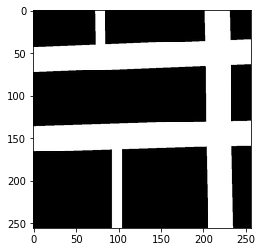

In [30]:
plt.imshow(target_image.squeeze(0), cmap='Greys_r')

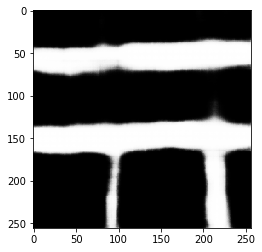

In [31]:
plt.imshow(output_image.detach().cpu().numpy(), cmap='Greys_r')

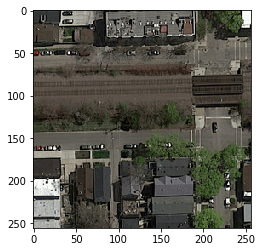

In [32]:
plt.imshow(validation_input[11].swapaxes(1,2).swapaxes(0,2))

In [17]:
np.savetxt('losstrain.csv', losstrain, delimiter=',')
np.savetxt('loss_validation.csv', loss_validation, delimiter=',')


Load the test data

In [33]:
root_dir = "test_set_images/"
test_images=[]
for i in range(1, 51):
    image_filename = root_dir + "test_" + str(i) + "/test_" + str(i) + '.png'
    test_images.append(np.array(load_image(image_filename)).swapaxes(0,2).swapaxes(1,2))
    test_images
print(np.shape(test_images))

(50, 3, 608, 608)


The file is bigger than 100*100! we need to cut it into 100*100 parts.

In [39]:

crop = 256
masks = []
for test_image in test_images:
    _, im_height, im_width = np.shape(test_image)
    imgheight = test_image.shape[1]
    imgwidth = test_image.shape[2]
    mask = torch.zeros(1, imgheight, imgwidth)
    for i in range(0, imgheight, crop):
        for j in range(0, imgwidth, crop):
            # when the crop is bigger than the image size, we increase the temporary image with 0
            if(i+crop>imgheight and j+crop>imgwidth):
                im_patch = np.zeros([3,crop,crop],dtype = np.float32)
                im_patch[:, :imgheight-i, :imgwidth-j] = test_image[:, i:imgheight, j:imgwidth]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:imgheight, j:imgwidth] = model(im_patch.float()).detach()[0,0,:imgheight-i,:imgwidth-j]
            
            elif(i+crop>imgheight):
                im_patch = np.zeros([3,crop,crop],dtype = np.float32)
                im_patch[:, :imgheight-i, :] = test_image[:, i:imgheight, j:j+crop]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:imgheight, j:j+crop] = model(im_patch.float()).detach()[0,0,:imgheight-i,:]
            
            elif(j+crop>imgwidth):
                im_patch = np.zeros([3,crop,crop])
                im_patch[:, :, :imgwidth-j] = test_image[:, i:i+crop, j:imgwidth]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:i+crop, j:imgwidth] = model(im_patch.float()).detach()[0,0,:,:imgwidth-j]
            
            else: # cas normal
                im_patch = test_image[:, i:i+crop, j:j+crop]
                im_patch = torch.tensor(im_patch).unsqueeze(0).to(device)
                mask[:, i:i+crop, j:j+crop] = model(im_patch).detach()[0,0,:,:]
    masks.append(mask.numpy())

In [40]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[2], patch_size):
            patch = image[0][i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        i=int(0)
        for image in images[0:]:
            i+=1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(image,i))


In [41]:
submission_filename = 'submission.csv'
masks_to_submission(submission_filename, *masks)